In [2]:
import os
os.chdir("./..")
print(os.getcwd())


import pandas as pd
import json
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import random


from scripts.utils_models import *


/home/dalai/GNN_E


ModuleNotFoundError: No module named 'scripts.utils_models'

# Distribution Labels Vertical Train/Test

In [15]:
num_classes = 13
type_labels = "single"

df_all_movies = pd.read_csv(f"data/processed/all_movies_labelled_{num_classes}_{type_labels}.csv")

df_all_movies

,Unnamed: 0,vindex,score,id,movie,timestamp_tr,label
0,0,0,-21.180140,1,0,0,-1
1,1,0,-14.295689,1,0,1,-1
2,2,0,-5.882564,1,0,2,-1
3,3,0,30.127113,1,0,3,-1
4,4,0,41.830845,1,0,4,-1
...,...,...,...,...,...,...,...
118876369,118876369,413,-21.945122,32,13,763,-1
118876370,118876370,413,3.040432,32,13,764,-1
118876371,118876371,413,-36.525375,32,13,765,-1
118876372,118876372,413,-7.233601,32,13,766,-1


<Axes: xlabel='label'>

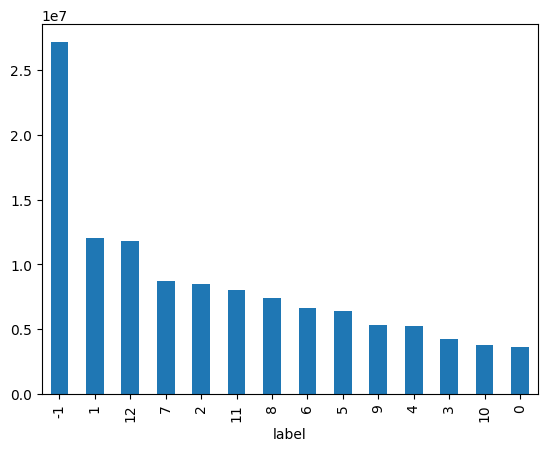

In [5]:
df_all_movies["label"].value_counts().plot.bar()

## Try to Rebalance

In [71]:
# Calculate the label counts 
label_counts_normalized = df_all_movies['label'].value_counts().sort_values() / 414

# Print the first label's normalized count (if you want just the first value)
print(label_counts_normalized[0])
print(label_counts_normalized.index[0])


# Alternatively, if you want to see the entire normalized distribution
print(label_counts_normalized)

8670.0
0
label
 0      8670.0
 10     9180.0
 3     10320.0
 4     12600.0
 9     12810.0
 5     15540.0
 6     16080.0
 8     17820.0
 11    19410.0
 2     20460.0
 7     20970.0
 12    28590.0
 1     29100.0
-1     65591.0
Name: count, dtype: float64


8670
-1
0
1
Number of groups: 29100
Each group has 414 elements.


Processing Groups: 100%|██████████| 20430/20430 [11:15<00:00, 30.25group/s]



2
Number of groups: 20460
Each group has 414 elements.


Processing Groups: 100%|██████████| 11790/11790 [04:55<00:00, 39.94group/s]



3
Number of groups: 10320
Each group has 414 elements.


Processing Groups: 100%|██████████| 1650/1650 [00:20<00:00, 79.83group/s]



4
Number of groups: 12600
Each group has 414 elements.


Processing Groups: 100%|██████████| 3930/3930 [00:59<00:00, 66.23group/s]



5
Number of groups: 15540
Each group has 414 elements.


Processing Groups: 100%|██████████| 6870/6870 [02:10<00:00, 52.68group/s]



6
Number of groups: 16080
Each group has 414 elements.


Processing Groups: 100%|██████████| 7410/7410 [02:27<00:00, 50.26group/s]



7
Number of groups: 20970
Each group has 414 elements.


Processing Groups: 100%|██████████| 12300/12300 [05:06<00:00, 40.16group/s]



8
Number of groups: 17820
Each group has 414 elements.


Processing Groups: 100%|██████████| 9150/9150 [03:07<00:00, 48.81group/s]



9
Number of groups: 12810
Each group has 414 elements.


Processing Groups: 100%|██████████| 4140/4140 [01:00<00:00, 67.90group/s]



10
Number of groups: 9180
Each group has 414 elements.


Processing Groups: 100%|██████████| 510/510 [00:05<00:00, 95.13group/s]



11
Number of groups: 19410
Each group has 414 elements.


Processing Groups: 100%|██████████| 10740/10740 [04:00<00:00, 44.66group/s]



12
Number of groups: 28590
Each group has 414 elements.


Processing Groups: 100%|██████████| 19920/19920 [11:05<00:00, 29.91group/s]


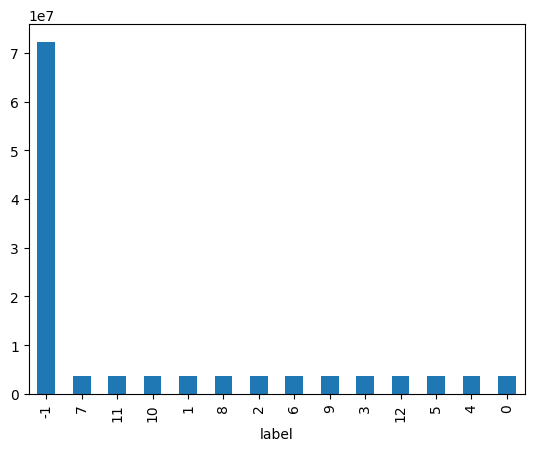

In [ ]:
df_all_movies_balanced = df_all_movies.copy()

# Step 1: Find the class with the least observations
class_counts = df_all_movies['label'].value_counts()

# The class with the least number of observations
label_counts_normalized = df_all_movies['label'].value_counts().sort_values() / 414
min_class_count = int(label_counts_normalized[0])
print(min_class_count)

# Step 2: Down-sample the other classes
def downsample_class(df, label, min_count):
    # Get all the rows for this class
    class_df = df[df['label'] == label]

    # Here in each grpu there are 414 nodes
    grouped = class_df.groupby(by=["movie", "id", "timestamp_tr"])

    print(f"Number of groups: {grouped.ngroups}")

    group_sizes = grouped.size()
    if (group_sizes == 414).all():
        print("Each group has 414 elements.")
    else:
        print("Some groups do not have 414 elements.")

    # Get the list of all unique groups
    all_groups = list(grouped.groups.keys())

    # number of labels to remove
    n_to_remove = grouped.ngroups - min_count

    # Randomly sample 'min_count' groups
    sampled_groups = random.sample(all_groups, n_to_remove)

    # Set the label to -1 for all rows in the sampled groups
    for group in tqdm(sampled_groups, desc="Processing Groups", unit="group"):
        movie, id, timestamp_tr = group
        #print(f"Setting label to -1 for group: {movie}, {id}, {timestamp_tr}")

        # Get the indices for rows in this group and set their label to -1
        group_indices = class_df[(class_df['movie'] == movie) &
                                  (class_df['id'] == id) &
                                  (class_df['timestamp_tr'] == timestamp_tr)].index
        df.loc[group_indices, 'label'] = -1
    
    return df

# Step 3: Apply the down-sampling to each class
exclude_labels = [-1, label_counts_normalized.index[0]]
for label in sorted(class_counts.index):
    print(label)
    if label not in exclude_labels:
        df_all_movies_balanced = downsample_class(df_all_movies_balanced, label, min_class_count)
    print()


# Check the result
df_all_movies_balanced["label"].value_counts().plot.bar()


# Save
#df_all_movies_balanced.to_csv(f"data/processed/all_movies_labelled_13_single_balanced.csv")

## Some Checks

In [ ]:
#df_all_movies_balanced = pd.read_csv(f"data/processed/all_movies_labelled_13_single_balanced.csv")


Are labels for vindex 2 and 6 the same? True


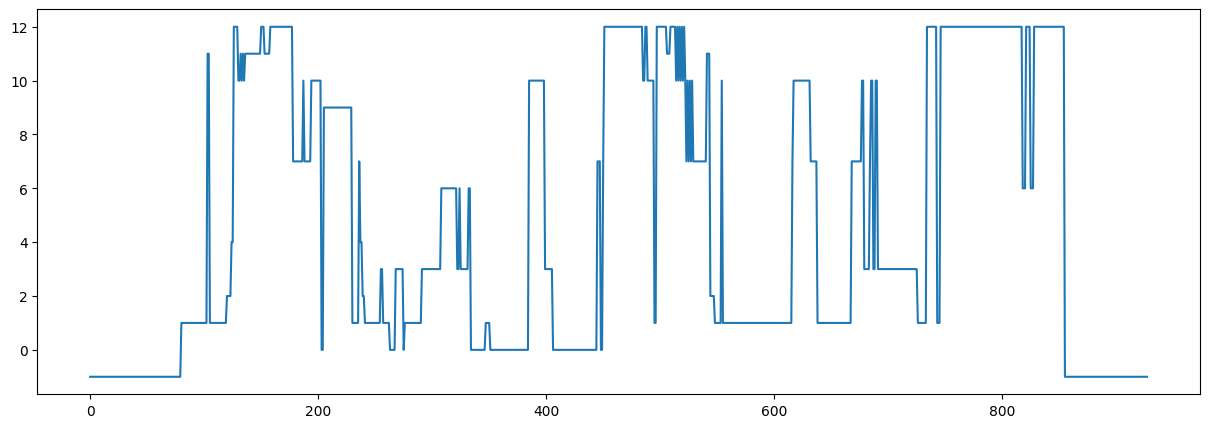

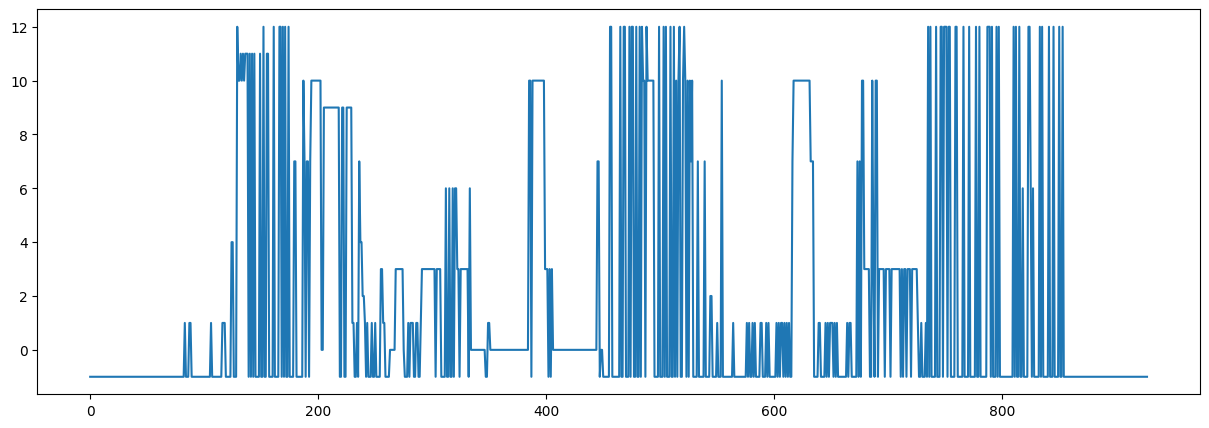

In [18]:
# Same moive and subject but differt vindex should have same lables  evloution time
# Extract subsets for vindex 2 and vindex 6
labels_vindex_2 = df_all_movies_balanced[
    (df_all_movies_balanced.movie == 6) & 
    (df_all_movies_balanced.vindex == 2) & 
    (df_all_movies_balanced.id == 1)
]["label"].reset_index(drop=True)
labels_vindex_6 = df_all_movies_balanced[
    (df_all_movies_balanced.movie == 6) & 
    (df_all_movies_balanced.vindex == 6) & 
    (df_all_movies_balanced.id == 1)
]["label"].reset_index(drop=True)
# Compare the two label evolutions
are_labels_equal = labels_vindex_2.equals(labels_vindex_6)
print(f"Are labels for vindex 2 and 6 the same? {are_labels_equal}")




plt.figure(figsize=(15, 5))
df_all_movies[(df_all_movies.movie == 6) & (df_all_movies.vindex == 2) & (df_all_movies.id == 1)]["label"].reset_index(drop=True).plot()
plt.show()

plt.figure(figsize=(15, 5))
df_all_movies_balanced[(df_all_movies_balanced.movie == 6) & (df_all_movies_balanced.vindex == 2) & (df_all_movies_balanced.id == 1)]["label"].reset_index(drop=True).plot()
plt.show()


<Axes: >

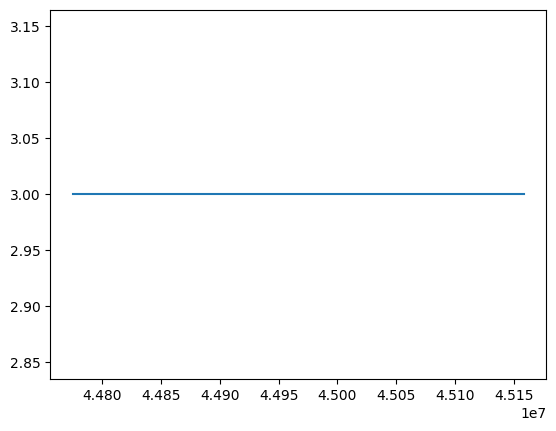

In [19]:
# sam e sub and same movie shoudl have all equale labels for a sefici tr in each vindex
df_all_movies_balanced[(df_all_movies_balanced.movie == 6) & (df_all_movies_balanced.timestamp_tr == 700) & (df_all_movies_balanced.id == 1)]["label"].plot()

In [25]:
print(df_all_movies_balanced[df_all_movies_balanced.label != -1].shape)
print(df_all_movies[df_all_movies.label != -1].shape)
# Calculate the percentage reduction in the number of rows after down-sampling (excluding rows labeled as -1)
reduction_percentage = ((df_all_movies[df_all_movies.label != -1].shape[0] - 
                         df_all_movies_balanced[df_all_movies_balanced.label != -1].shape[0]) / 
                        df_all_movies[df_all_movies.label != -1].shape[0]) * 100

print(f"Percentage reduction in rows after down-sampling: {reduction_percentage:.2f}%")

(46661940, 8)
(91721700, 7)
Percentage reduction in rows after down-sampling: 49.13%


## Calculate KL Diverge to find best Split

In [21]:
from itertools import combinations
from scipy.stats import entropy
import numpy as np
import pandas as pd
from tqdm import tqdm

# Step 1: Identify unique movies
movies = df_all_movies_balanced['movie'].unique()

# Precompute normalized label distributions for each movie
movie_distributions = {}
all_labels = np.arange(df_all_movies_balanced['label'].min(), df_all_movies_balanced['label'].max() + 1)

for movie in movies:
    movie_data = df_all_movies_balanced[df_all_movies_balanced['movie'] == movie]
    label_counts = movie_data['label'].value_counts(normalize=True)
    movie_distributions[movie] = np.array([label_counts.get(label, 0) for label in all_labels])

# Functions to compute JSD and KL Divergence
def jensen_shannon_divergence(p, q):
    p = np.where(p == 0, 1e-10, p)  # Avoid division by zero
    q = np.where(q == 0, 1e-10, q)
    m = 0.5 * (p + q)
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

def kl_divergence(p, q):
    p = np.where(p == 0, 1e-10, p)  # Avoid division by zero
    q = np.where(q == 0, 1e-10, q)
    return entropy(p, q)

# Step 2: Generate combinations of movies for Train
movie_combinations = list(combinations(movies, 3))  # Adjust size as needed for scalability

# Step 3: Calculate JSD and KL for each combination and store results
results = []

for train_movies in tqdm(movie_combinations, desc="Processing Movie Combinations"):
    # Split data into Train and Test
    test_movies = set(movies) - set(train_movies)
    
    # Aggregate label distributions for Train and Test
    train_distribution = sum(movie_distributions[movie] for movie in train_movies)
    test_distribution = sum(movie_distributions[movie] for movie in test_movies)
    
    # Normalize aggregated distributions
    train_distribution /= train_distribution.sum()
    test_distribution /= test_distribution.sum()
    
    # Calculate JSD and KL Divergence
    jsd = jensen_shannon_divergence(train_distribution, test_distribution)
    kl = kl_divergence(train_distribution, test_distribution)
    
    # Store combination, JSD, and KL scores
    results.append({
        "Train Movies": train_movies,
        "Test Movies": tuple(test_movies),
        "JSD": jsd,
        "KL": kl
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Step 4: Sort the DataFrame by JSD (and optionally by KL) in ascending order
results_df = results_df.sort_values(by="JSD").reset_index(drop=True)

# Display the top results
print(results_df.head())


Processing Movie Combinations: 100%|██████████| 364/364 [00:00<00:00, 1022.35it/s]

  Train Movies                            Test Movies       JSD        KL
0   (4, 9, 13)   (0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12)  0.006906  0.028965
1   (7, 9, 11)   (0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 13)  0.007555  0.029749
2    (5, 7, 9)  (0, 1, 2, 3, 4, 6, 8, 10, 11, 12, 13)  0.007582  0.030734
3    (1, 5, 7)  (0, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13)  0.007860  0.029692
4    (0, 7, 9)  (1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13)  0.009053  0.035913


In [22]:
df_train, df_test = split_train_test_vertically(
    df_all_movies_balanced, 
    test_movies_dict = {"FirstBite": 4, "Superhero": 9, "YouAgain": 13})

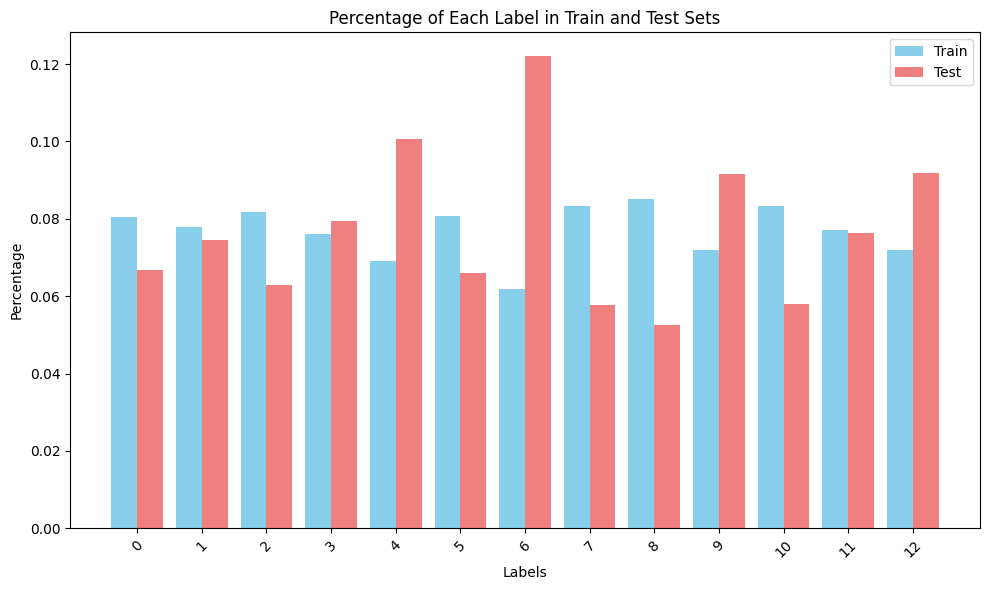

In [23]:
labels_train = df_train[df_train.label != -1]
labels_test = df_test[df_test.label != -1]

# Calculate percentage of each label in the train and test sets
train_label_counts = labels_train['label'].value_counts() / labels_train.shape[0]
test_label_counts = labels_test['label'].value_counts() / labels_test.shape[0]

# Get the labels present in both train and test sets
all_labels = set(train_label_counts.index).union(set(test_label_counts.index))

# Ensure all labels are represented in both sets (if absent, assign 0%)
train_label_counts = train_label_counts.reindex(all_labels)#, fillvalue=0)
test_label_counts = test_label_counts.reindex(all_labels)#, fillvalue=0)

# Create a bar plot with two bars side by side for each label
x = range(len(all_labels))

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for train and test sets side by side
width = 0.4  # Bar width
ax.bar([i - width/2 for i in x], train_label_counts, width=width, label='Train', color='skyblue')
ax.bar([i + width/2 for i in x], test_label_counts, width=width, label='Test', color='lightcoral')

# Add title and labels
ax.set_title("Percentage of Each Label in Train and Test Sets")
ax.set_xlabel("Labels")
ax.set_ylabel("Percentage")
ax.set_xticks(x)
ax.set_xticklabels(all_labels, rotation=45)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Accuracy

In [2]:
import os
os.chdir("./..")
print(os.getcwd())


import pandas as pd
import json
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import random
from datetime import datetime



def plot_acc(y_pred_train, y_true_train, y_pred_test, y_true_test):
    # Fixed number of labels (13 in this case)
    num_labels = 13

    # Align counts using bincount with a fixed number of 13 labels for both train and test sets
    y_true_train_counts = np.bincount(y_true_train, minlength=num_labels)
    y_pred_train_counts = np.bincount(y_pred_train, minlength=num_labels)
    y_true_test_counts = np.bincount(y_true_test, minlength=num_labels)
    y_pred_test_counts = np.bincount(y_pred_test, minlength=num_labels)

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # Bar width for side-by-side bars
    width = 0.3
    labels = np.arange(num_labels)  # Labels from 0 to 12 (13 labels)

    # Plot for Training Data (first subplot)
    axes[0].bar(labels - width / 2, y_true_train_counts, width=width, label='True Train Labels', color='blue', alpha=0.7)
    axes[0].bar(labels + width / 2, y_pred_train_counts, width=width, label='Predicted Train Labels', color='orange', alpha=0.7)

    # Styling for Training Plot (subplot 1)
    axes[0].set_xlabel('Labels')
    axes[0].set_ylabel('Counts')
    axes[0].set_title('Label Distribution: True vs Predicted (Train Data)')
    axes[0].set_xticks(labels)
    axes[0].legend()

    # Plot for Test Data (second subplot)
    axes[1].bar(labels - width / 2, y_true_test_counts, width=width, label='True Test Labels', color='green', alpha=0.7)
    axes[1].bar(labels + width / 2, y_pred_test_counts, width=width, label='Predicted Test Labels', color='red', alpha=0.7)

    # Styling for Test Plot (subplot 2)
    axes[1].set_xlabel('Labels')
    axes[1].set_ylabel('Counts')
    axes[1].set_title('Label Distribution: True vs Predicted (Test Data)')
    axes[1].set_xticks(labels)
    axes[1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the combined figure
    plt.show()

def plot_confustion_matrix(y_pred_train, y_true_train, y_pred_test, y_true_test):
    # Generate confusion matrices
    conf_matrix_train = confusion_matrix(y_true_train, y_pred_train)
    conf_matrix_test = confusion_matrix(y_true_test, y_pred_test)

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # Create heatmap for Train Data (first subplot)
    sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_true_train), yticklabels=np.unique(y_true_train), ax=axes[0])

    # Add borders to the diagonal cells in train heatmap
    for i in range(len(conf_matrix_train)):
        axes[0].add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

    axes[0].set_title('Confusion Matrix Heatmap (Train Data)')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Create heatmap for Test Data (second subplot)
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_true_test), yticklabels=np.unique(y_true_test), ax=axes[1])

    # Add borders to the diagonal cells in test heatmap
    for i in range(len(conf_matrix_test)):
        axes[1].add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

    axes[1].set_title('Confusion Matrix Heatmap (Test Data)')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the combined figure with both heatmaps
    plt.show()

def plot_loss(loss_train, loss_test):
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

    # Plot training loss in the first subplot
    axes[0].plot(loss_train, label='Training Loss', marker='o', color='blue')
    axes[0].set_title("Training Loss Over Epochs", fontsize=14)
    axes[0].set_xlabel("Epochs", fontsize=12)
    axes[0].set_ylabel("Loss", fontsize=12)
    axes[0].legend(fontsize=12)
    axes[0].grid(alpha=0.5)

    # Plot testing loss in the second subplot
    axes[1].plot(loss_test, label='Testing Loss', marker='x', color='red')
    axes[1].set_title("Testing Loss Over Epochs", fontsize=14)
    axes[1].set_xlabel("Epochs", fontsize=12)
    axes[1].set_ylabel("Loss", fontsize=12)
    axes[1].legend(fontsize=12)
    axes[1].grid(alpha=0.5)

    # Plot both training and testing loss together in the third subplot
    axes[2].plot(loss_train, label='Training Loss', marker='o', color='blue')
    axes[2].plot(loss_test, label='Testing Loss', marker='x', color='red')
    axes[2].set_title("Training vs Testing Loss", fontsize=14)
    axes[2].set_xlabel("Epochs", fontsize=12)
    axes[2].set_ylabel("Loss", fontsize=12)
    axes[2].legend(fontsize=12)
    axes[2].grid(alpha=0.5)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the combined figure
    plt.show()

def plot_accuracies_image(y_pred_train, y_true_train, y_pred_test, y_true_test):
    # Compute overall accuracy
    accuracy_train = accuracy_score(y_true_train, y_pred_train)
    accuracy_test = accuracy_score(y_true_test, y_pred_test)

    # Calculate per-class accuracy
    class_labels = np.unique(y_true_train)  # assuming both train and test have the same classes
    class_accuracies_train = []
    class_accuracies_test = []

    for class_label in class_labels:
        # For training data
        train_class_correct = np.sum((y_true_train == class_label) & (y_pred_train == class_label))
        train_class_total = np.sum(y_true_train == class_label)
        train_accuracy = train_class_correct / train_class_total if train_class_total > 0 else 0
        class_accuracies_train.append(train_accuracy)

        # For test data
        test_class_correct = np.sum((y_true_test == class_label) & (y_pred_test == class_label))
        test_class_total = np.sum(y_true_test == class_label)
        test_accuracy = test_class_correct / test_class_total if test_class_total > 0 else 0
        class_accuracies_test.append(test_accuracy)

    # Create a DataFrame to present the per-class accuracy
    accuracy_table_train = pd.DataFrame({
        'Class': class_labels,
        'Train Accuracy': class_accuracies_train
    })

    accuracy_table_test = pd.DataFrame({
        'Class': class_labels,
        'Test Accuracy': class_accuracies_test
    })

    # Overall accuracy summary
    overall_accuracy = pd.DataFrame({
        'Metric': ['Train Accuracy', 'Test Accuracy'],
        'Accuracy': [accuracy_train, accuracy_test]
    })

    # Create the plot
    fig, axes = plt.subplots(1,2, figsize=(10,4))

    # Plot the overall accuracy
    axes[0].bar(overall_accuracy['Metric'], overall_accuracy['Accuracy'], color=['blue', 'orange'])
    axes[0].set_title('Overall Accuracy')
    axes[0].set_ylabel('Accuracy')

    # Plot per-class accuracies for Train Data
    axes[1].bar(accuracy_table_train['Class'] - 0.2, accuracy_table_train['Train Accuracy'], width=0.4, label='Train Accuracy', color='blue')
    axes[1].bar(accuracy_table_test['Class'] + 0.2, accuracy_table_test['Test Accuracy'], width=0.4, label='Test Accuracy', color='orange')
    axes[1].set_title('Per-Class Accuracy')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


/home/dalai/GNN_E


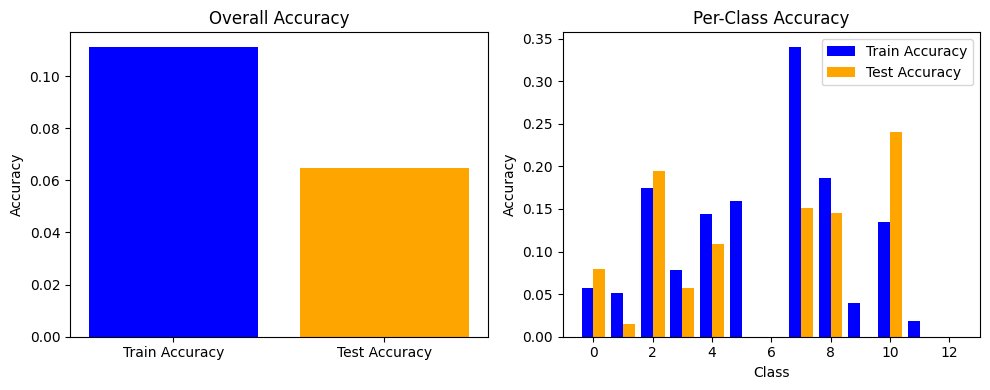

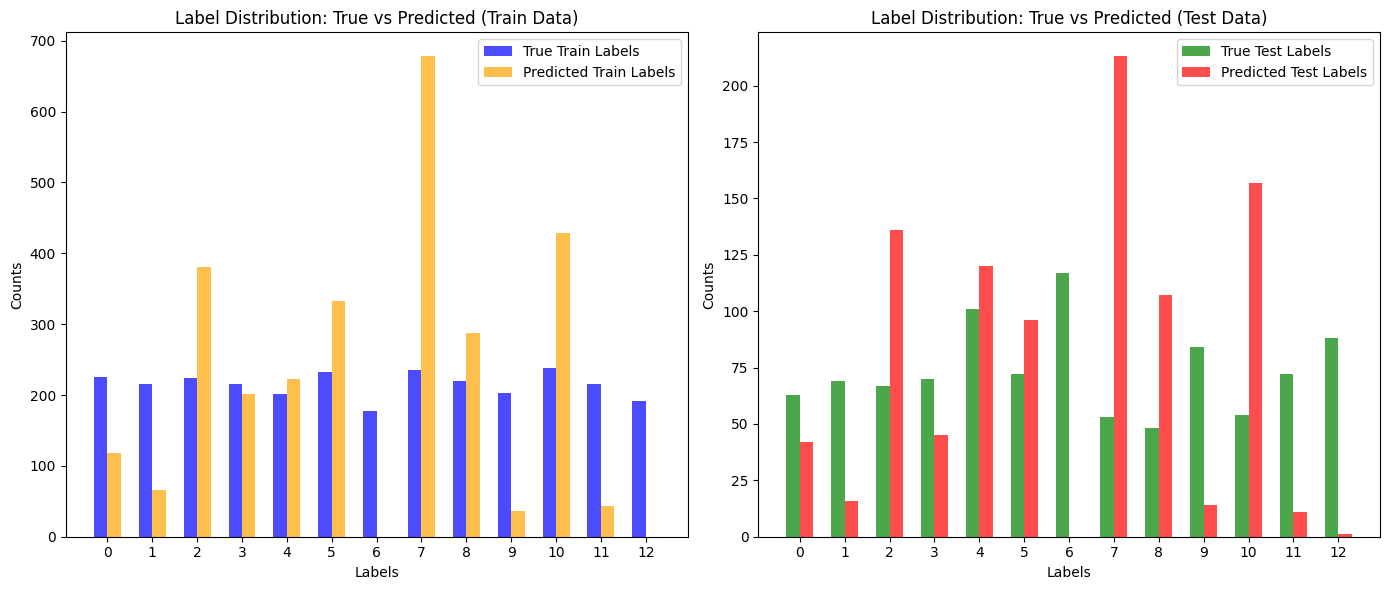

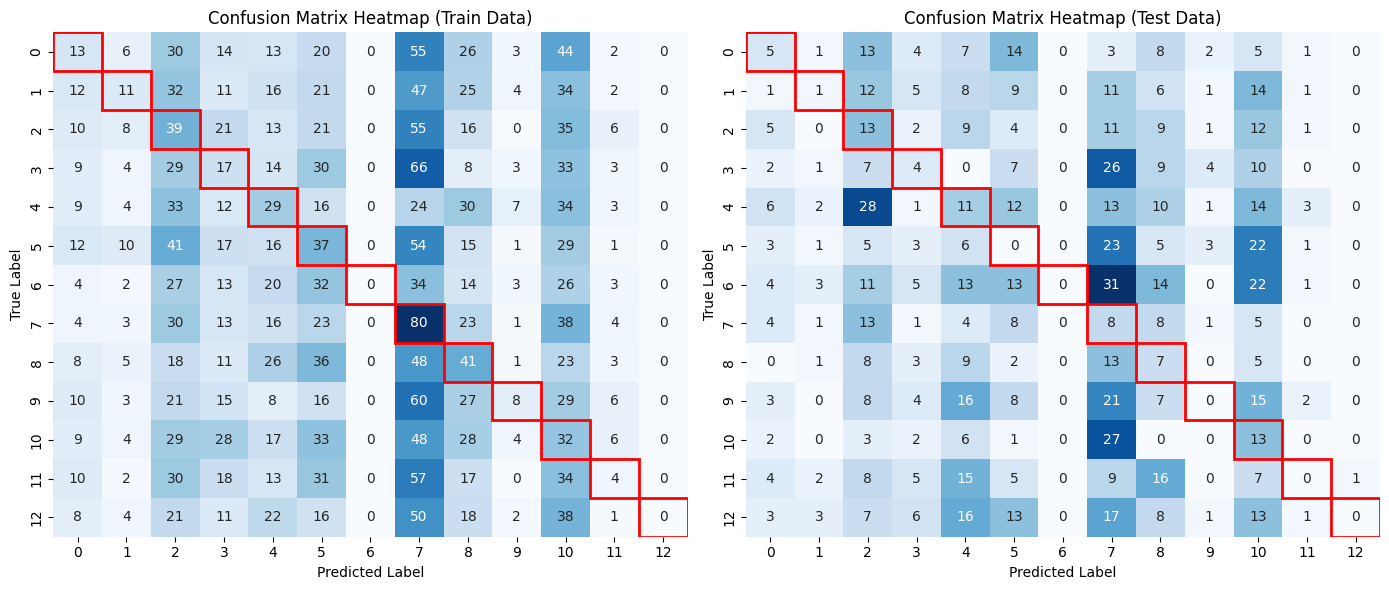

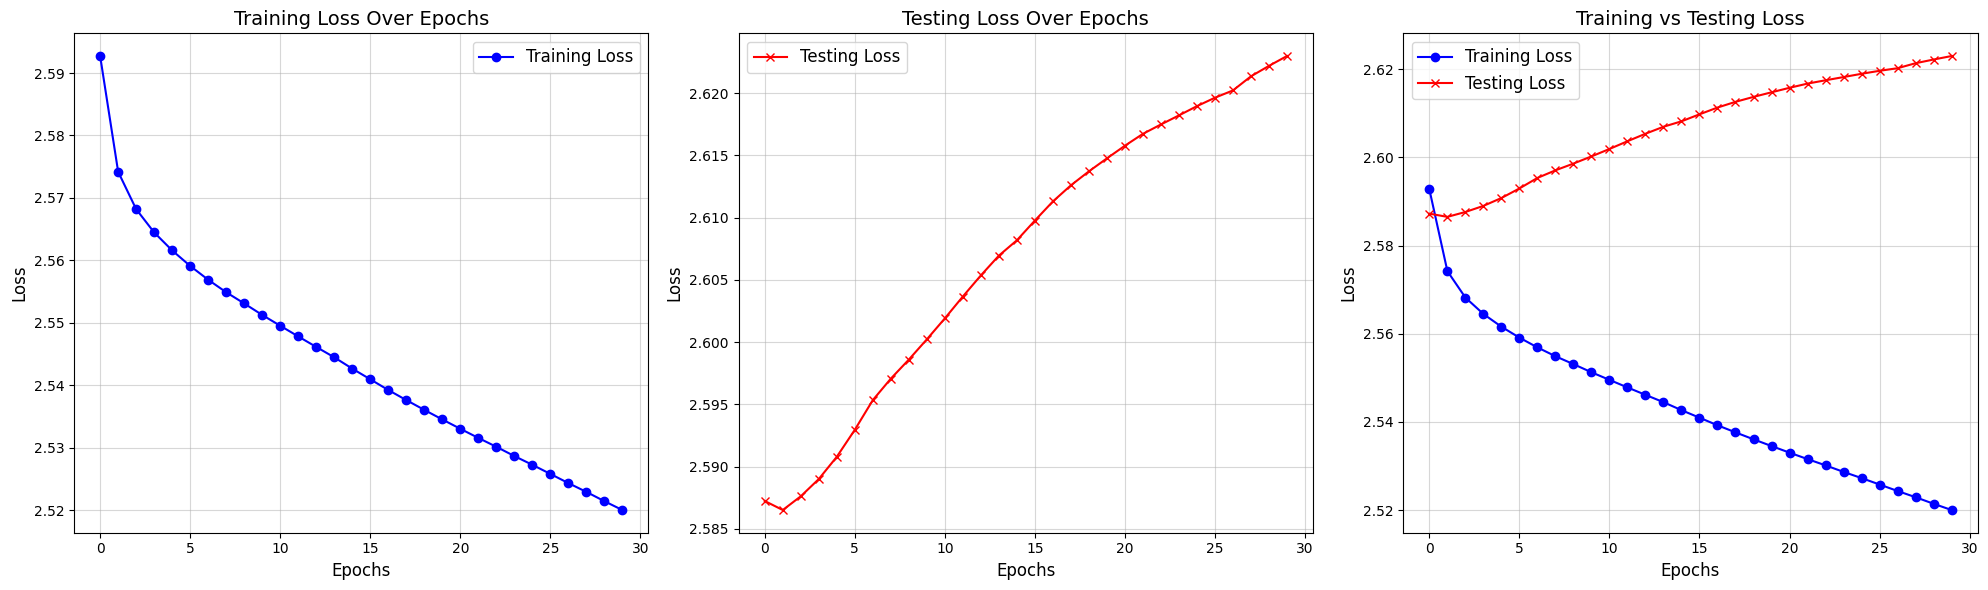

In [9]:
file_path = "/home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/2035-854/results.json"
file_path = "/home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1432-854/results.json"
file_path = "/home/dalai/GNN_E/data/results/GCN/balanced/14/all_emo/1037-647/results.json"

# Read the JSON file
with open(file_path, 'r') as f:
    results_dict = json.load(f)

y_pred_train = results_dict["pred_y_train"]
y_true_train= results_dict["y_train"]

y_pred_test = results_dict["pred_y_test"]
y_true_test= results_dict["y_test"]

loss_train = results_dict["train_losses"]
loss_test = results_dict["test_losses"]

plot_accuracies_image(y_pred_train, y_true_train, y_pred_test, y_true_test)
plot_acc(y_pred_train, y_true_train, y_pred_test, y_true_test)
plot_confustion_matrix(y_pred_train, y_true_train, y_pred_test, y_true_test)
plot_loss(loss_train, loss_test)

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/2185-886/results.json (Modified: 2024-12-07 20:58:34.067750)


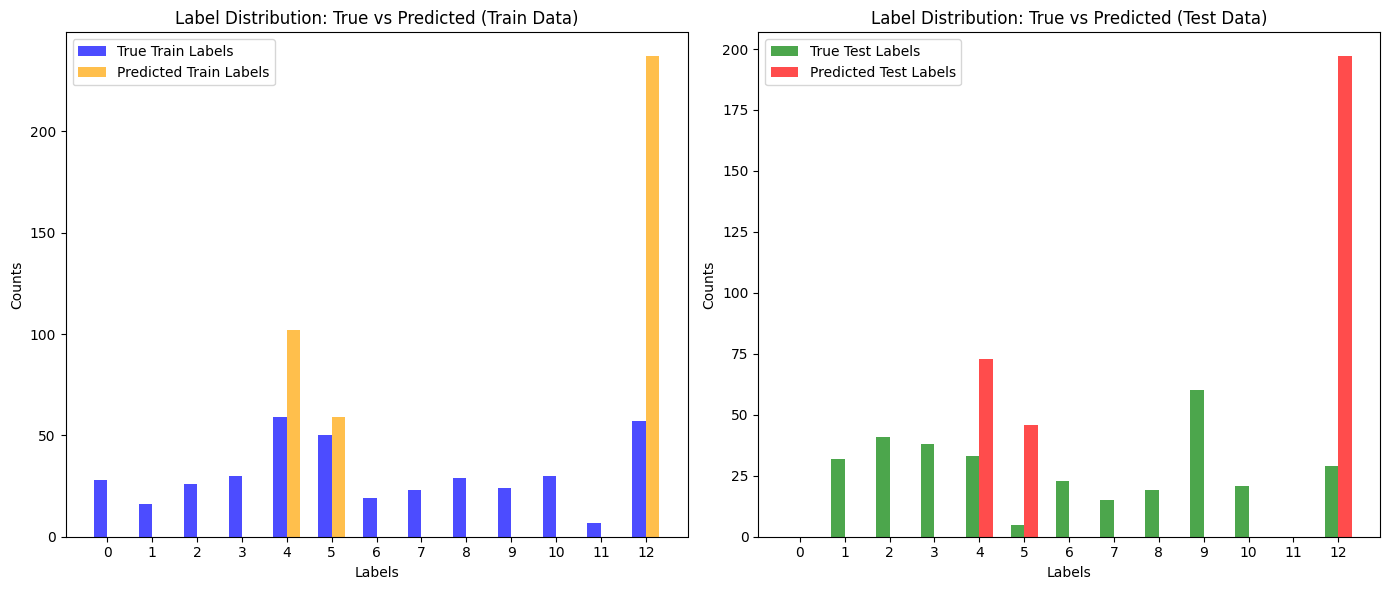

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/2135-1107/results.json (Modified: 2024-12-07 21:10:17.318731)


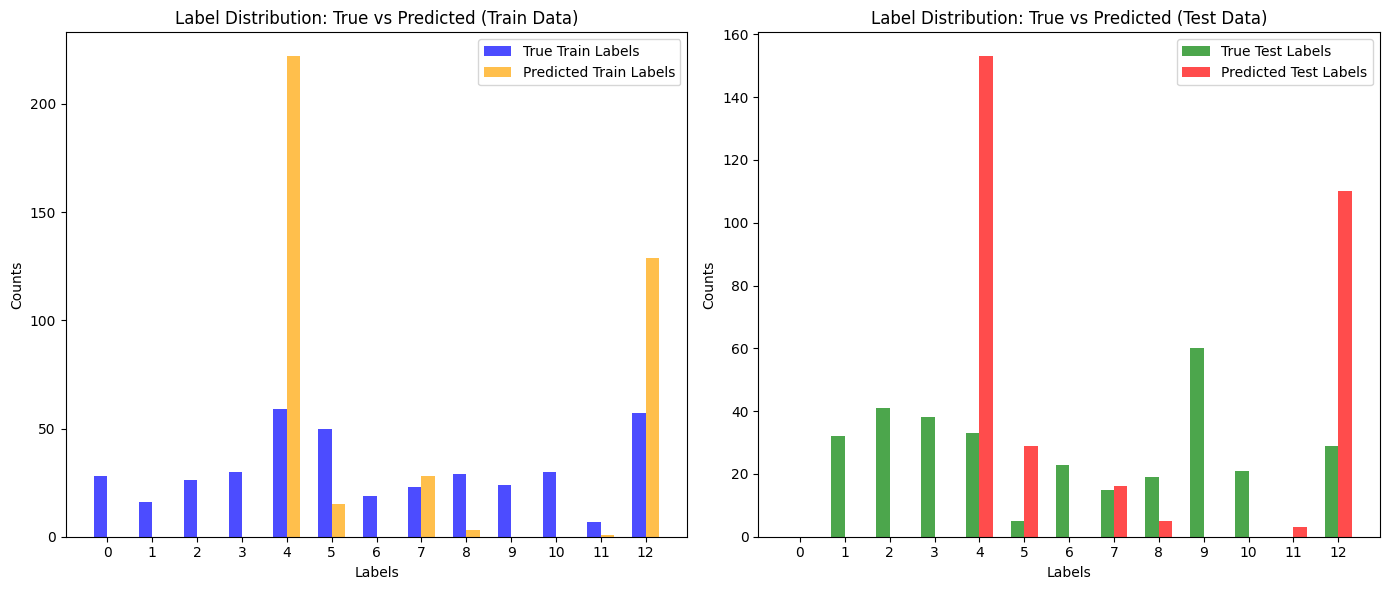

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/2035-854/results.json (Modified: 2024-12-07 20:17:23.514168)


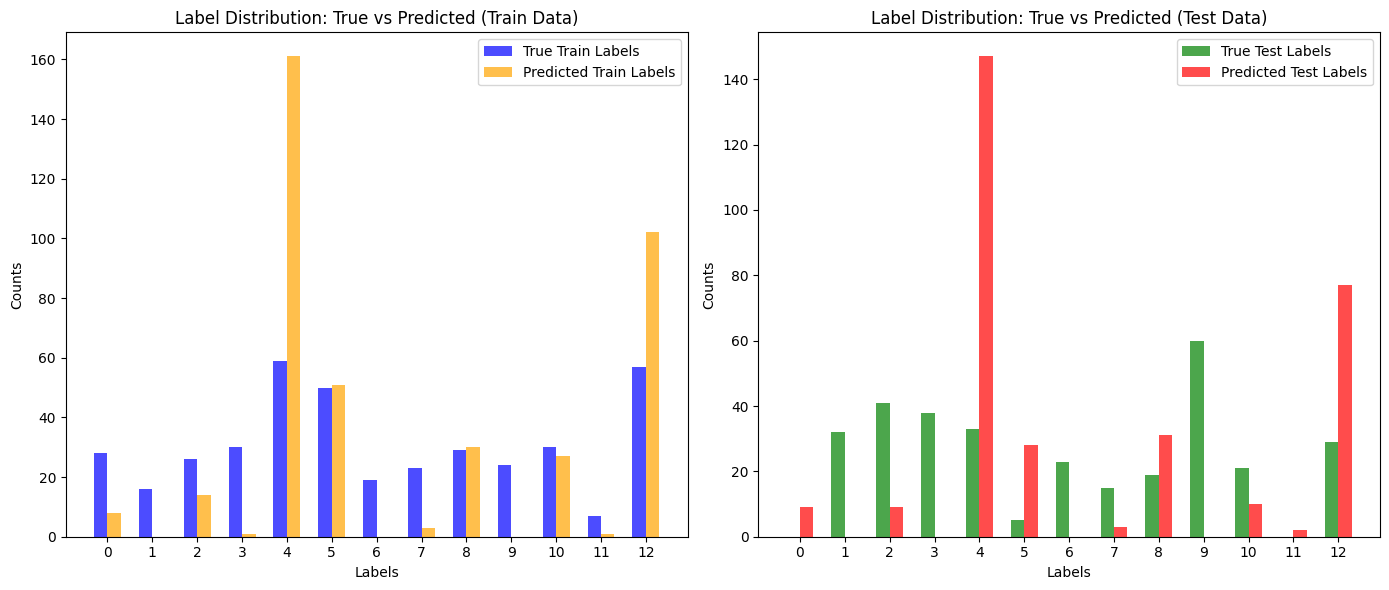

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1959-981/results.json (Modified: 2024-12-07 20:56:59.698757)


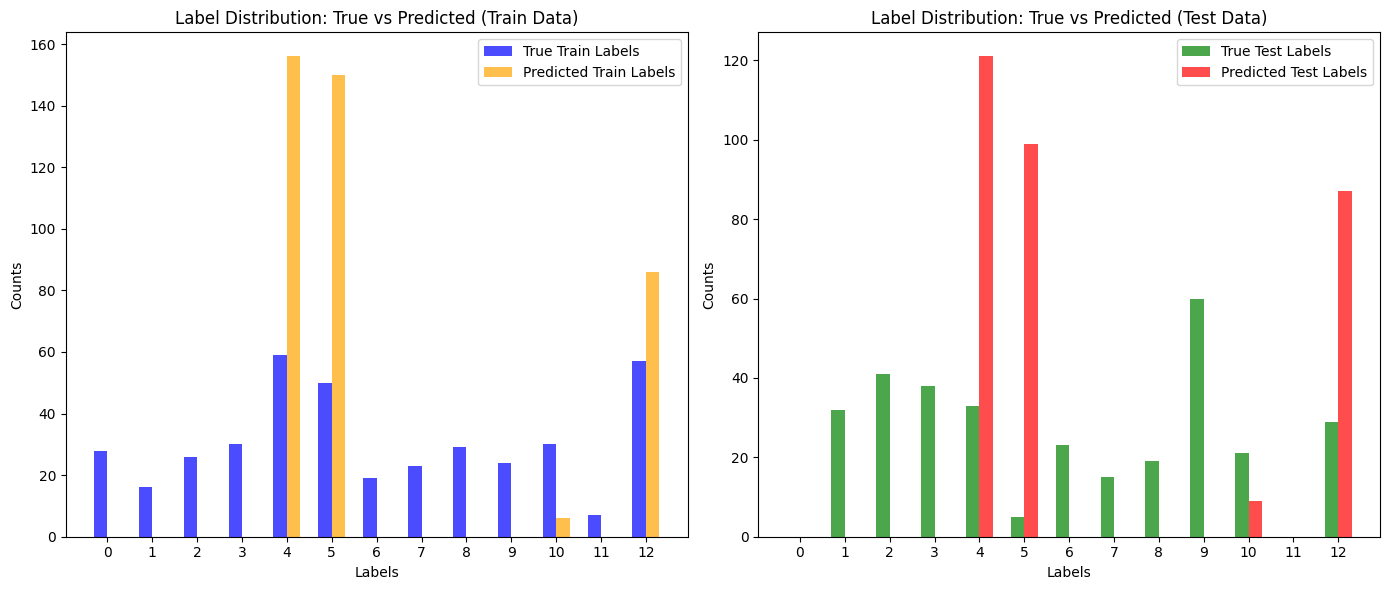

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1909-1044/results.json (Modified: 2024-12-07 21:47:38.464304)


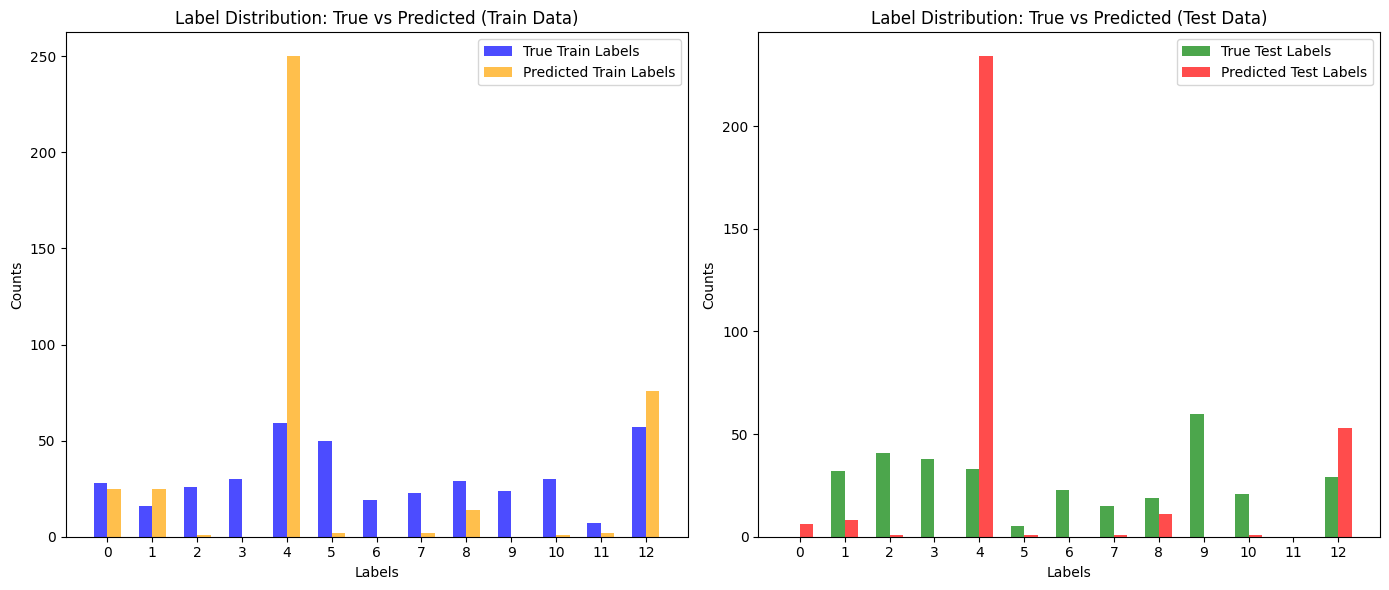

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1909-537/results.json (Modified: 2024-12-07 21:13:19.764478)


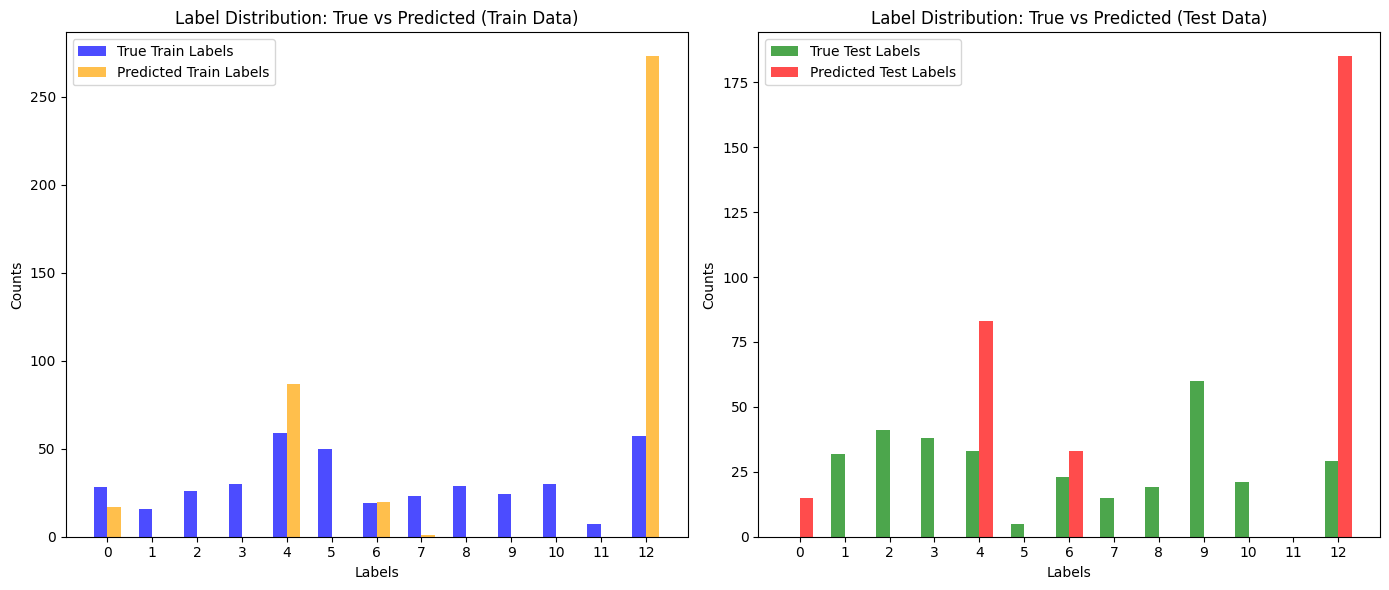

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1884-696/results.json (Modified: 2024-12-07 21:55:37.588873)


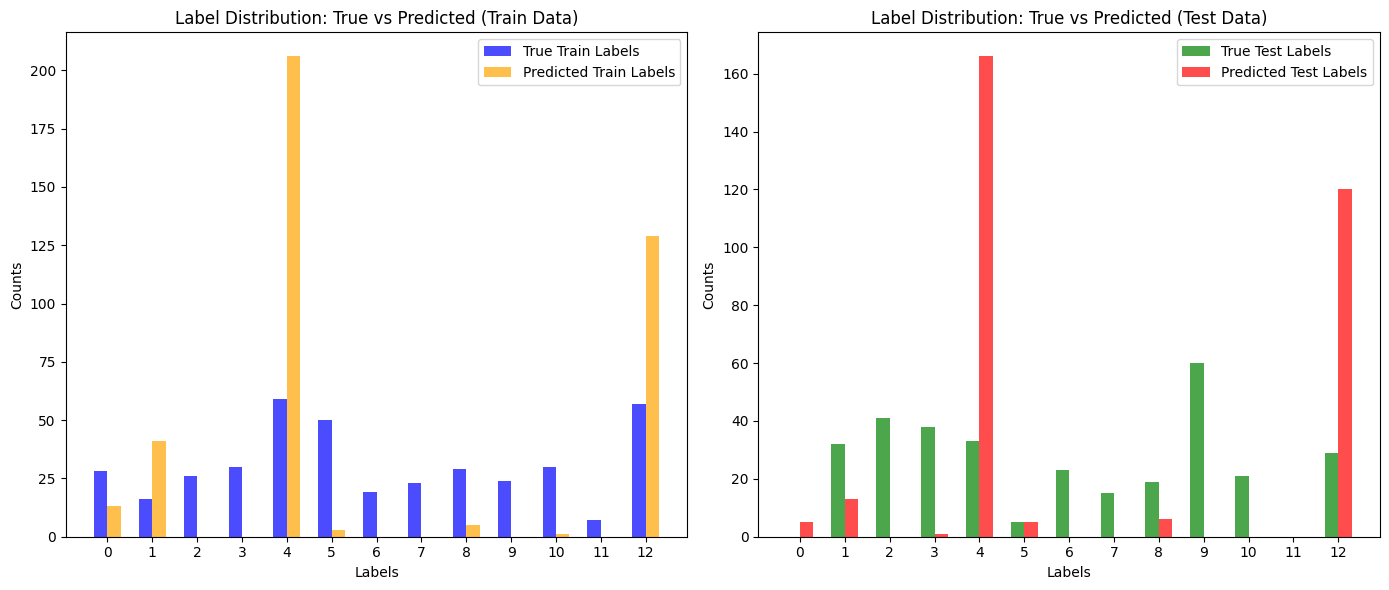

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1783-886/results.json (Modified: 2024-12-07 20:55:24.249731)


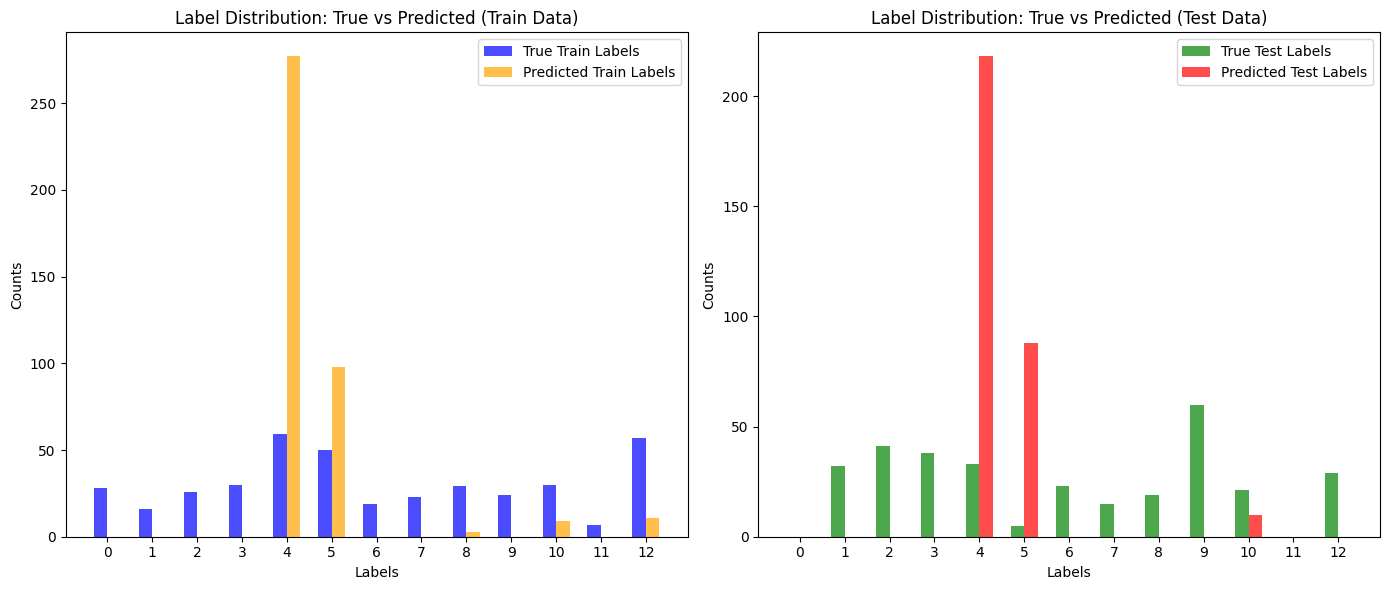

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1708-949/results.json (Modified: 2024-12-07 20:38:12.368306)


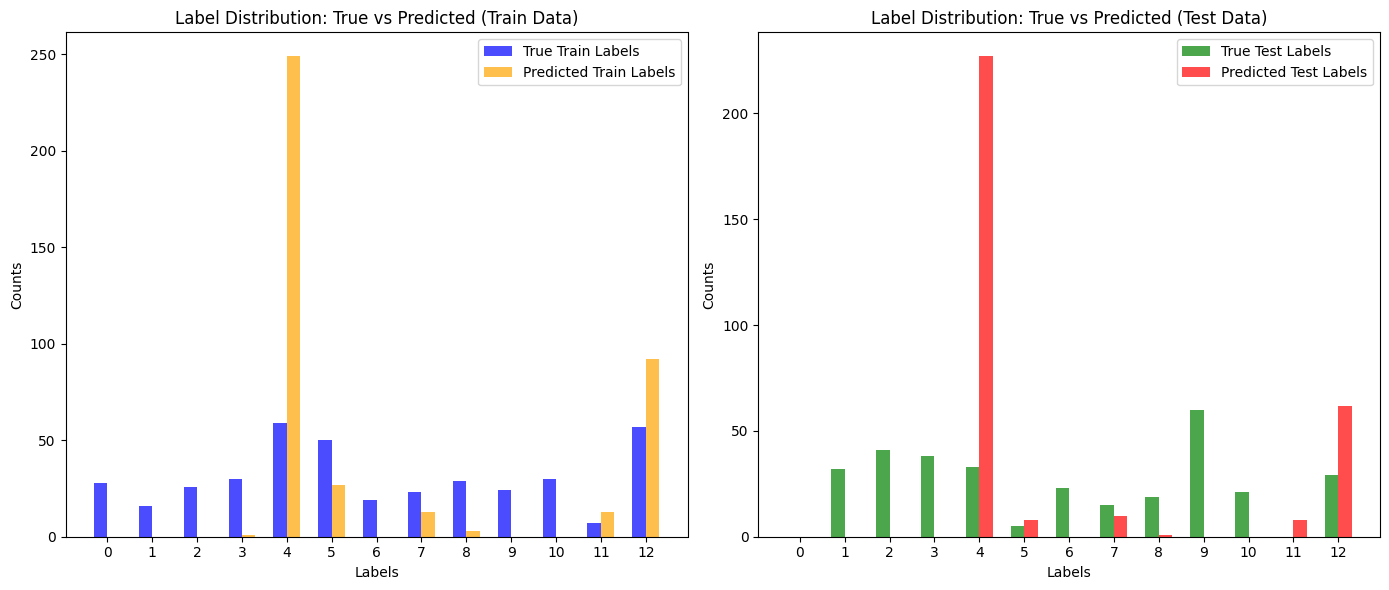

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1683-443/results.json (Modified: 2024-12-07 20:42:04.818363)


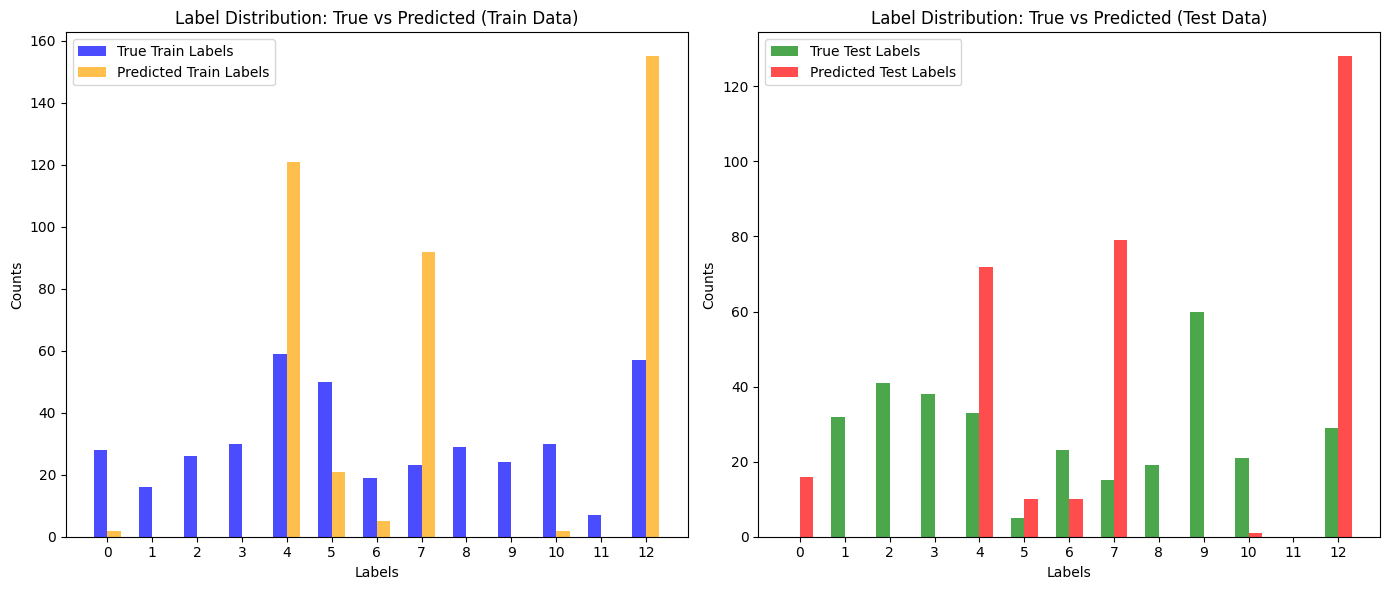

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1633-886/results.json (Modified: 2024-12-07 20:30:15.268219)


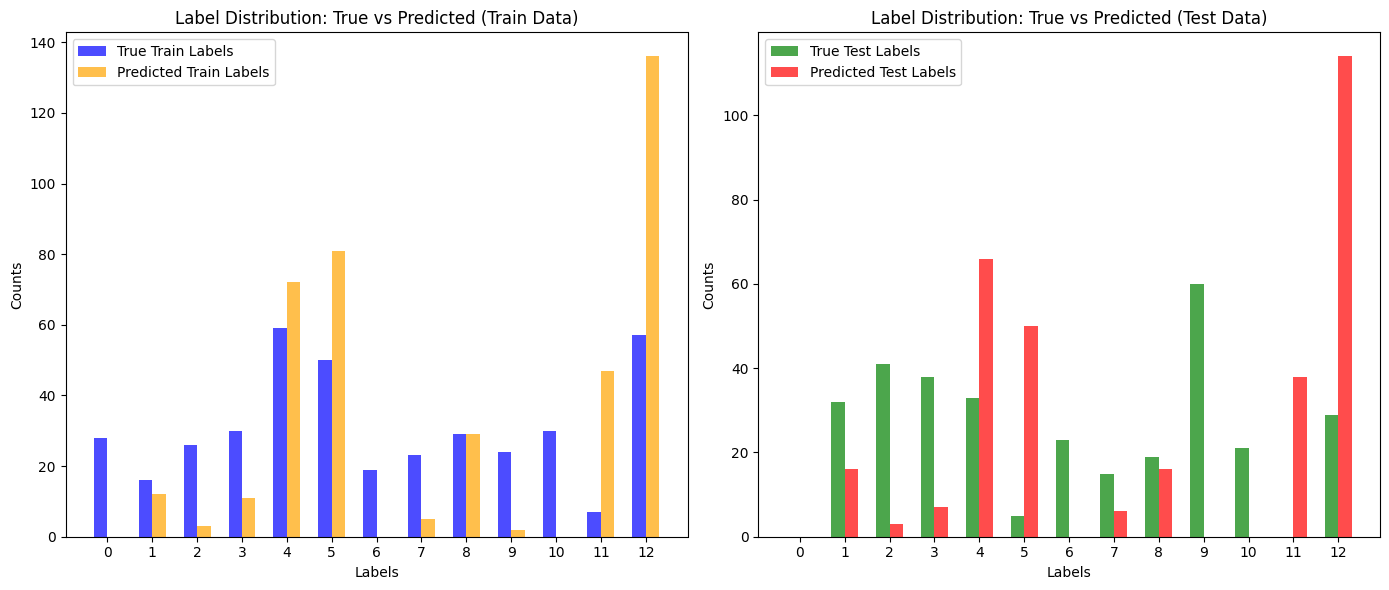

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1532-1392/results.json (Modified: 2024-12-07 20:53:45.004671)


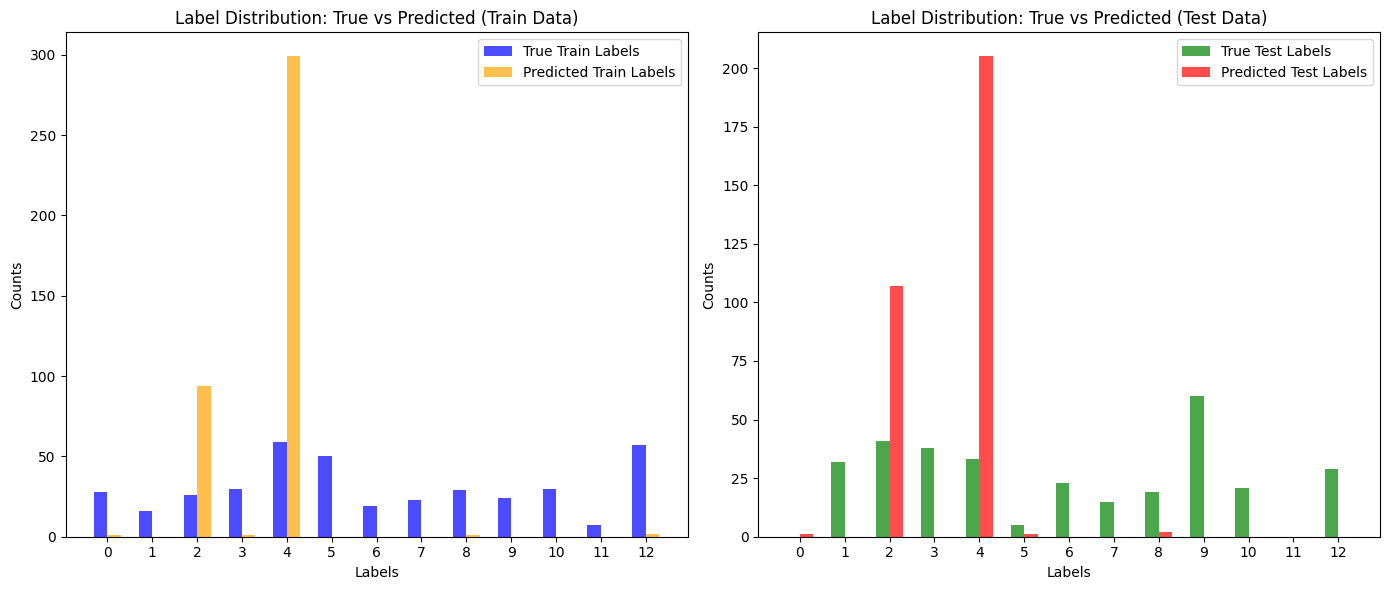

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1532-886/results.json (Modified: 2024-12-07 20:34:13.586230)


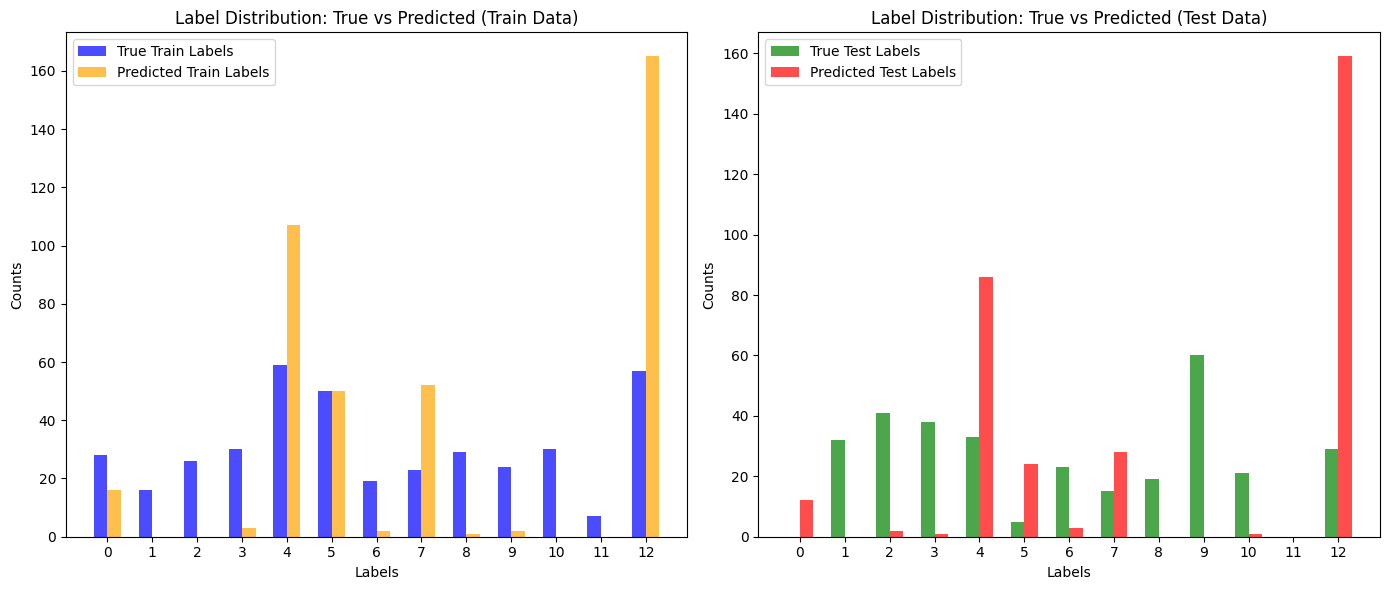

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1432-854/results.json (Modified: 2024-12-07 21:30:43.430433)


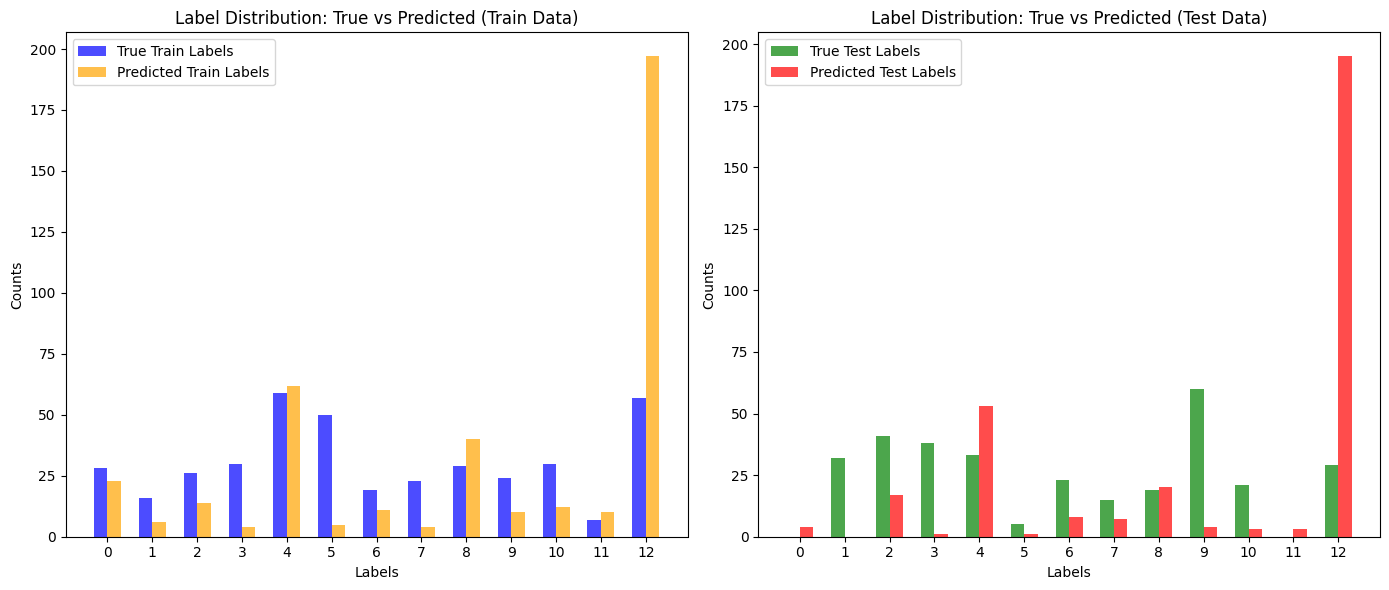

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1432-189/results.json (Modified: 2024-12-07 20:40:08.569331)


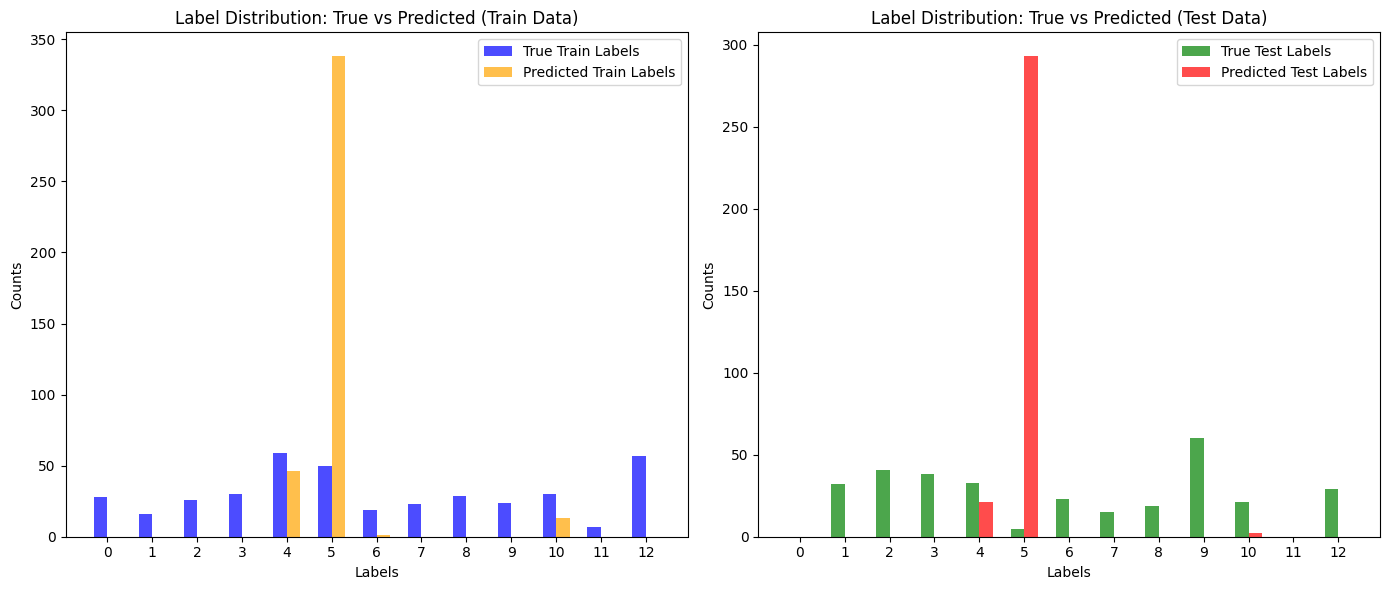

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1407-1044/results.json (Modified: 2024-12-07 21:53:39.043744)


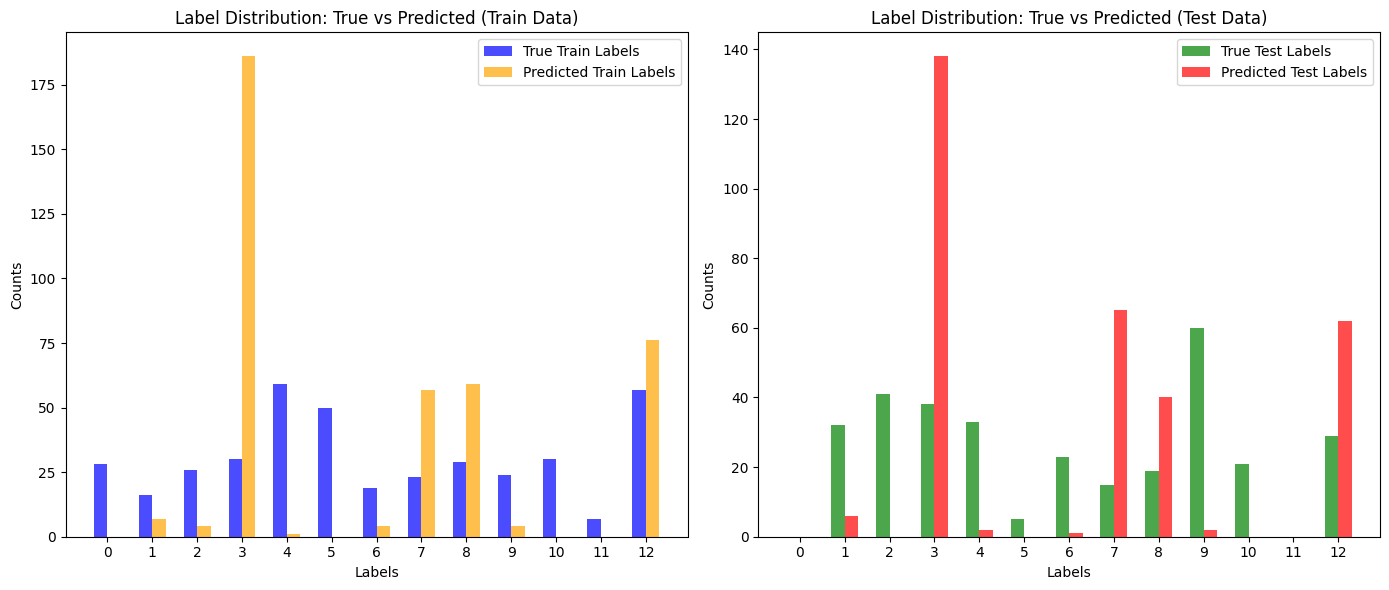

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1381-1107/results.json (Modified: 2024-12-07 21:45:40.059170)


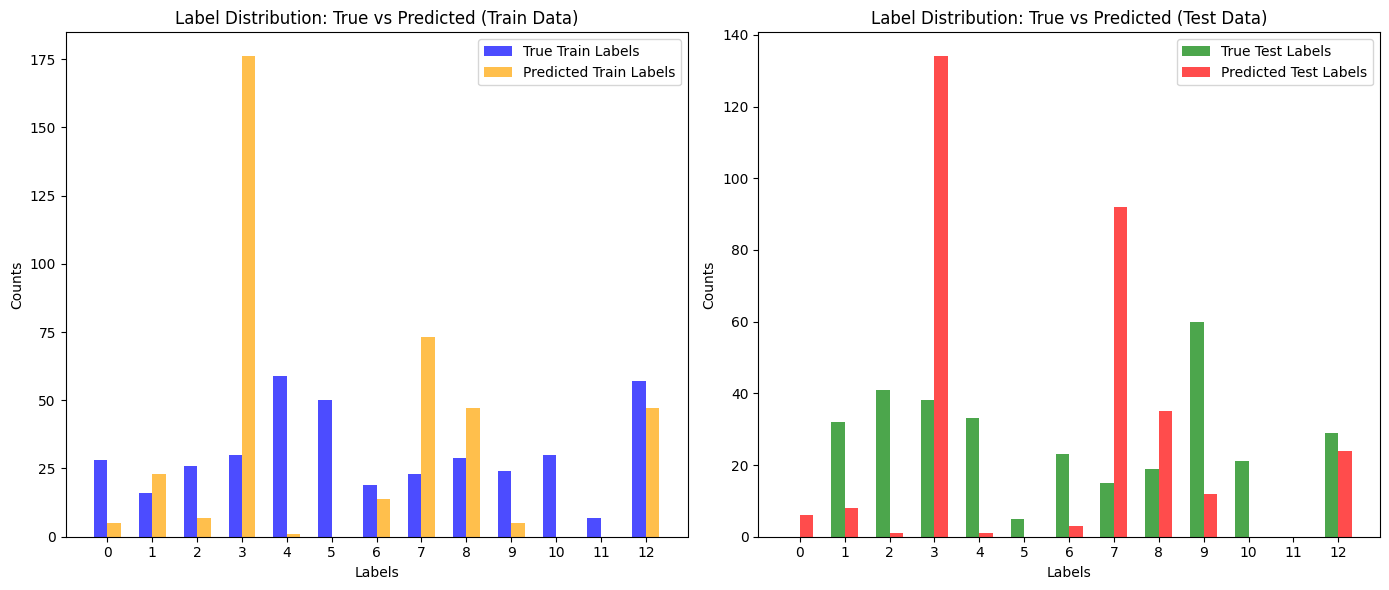

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1381-158/results.json (Modified: 2024-12-07 20:32:13.989211)


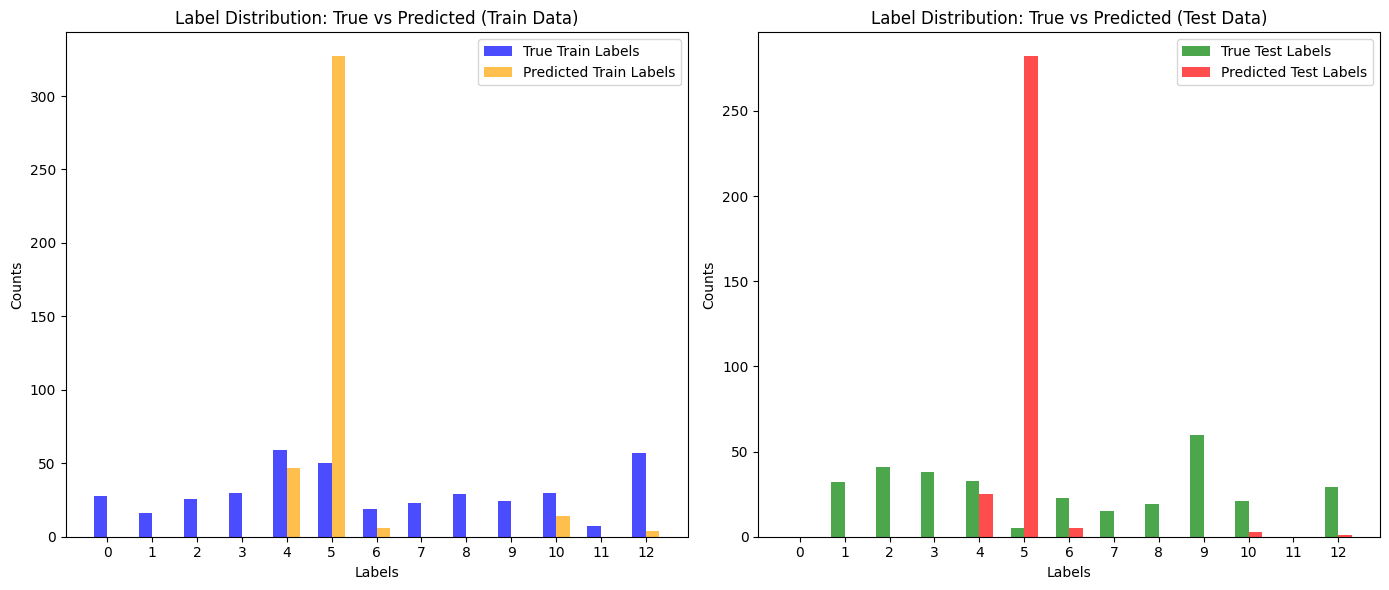

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1356-1550/results.json (Modified: 2024-12-07 21:03:32.742782)


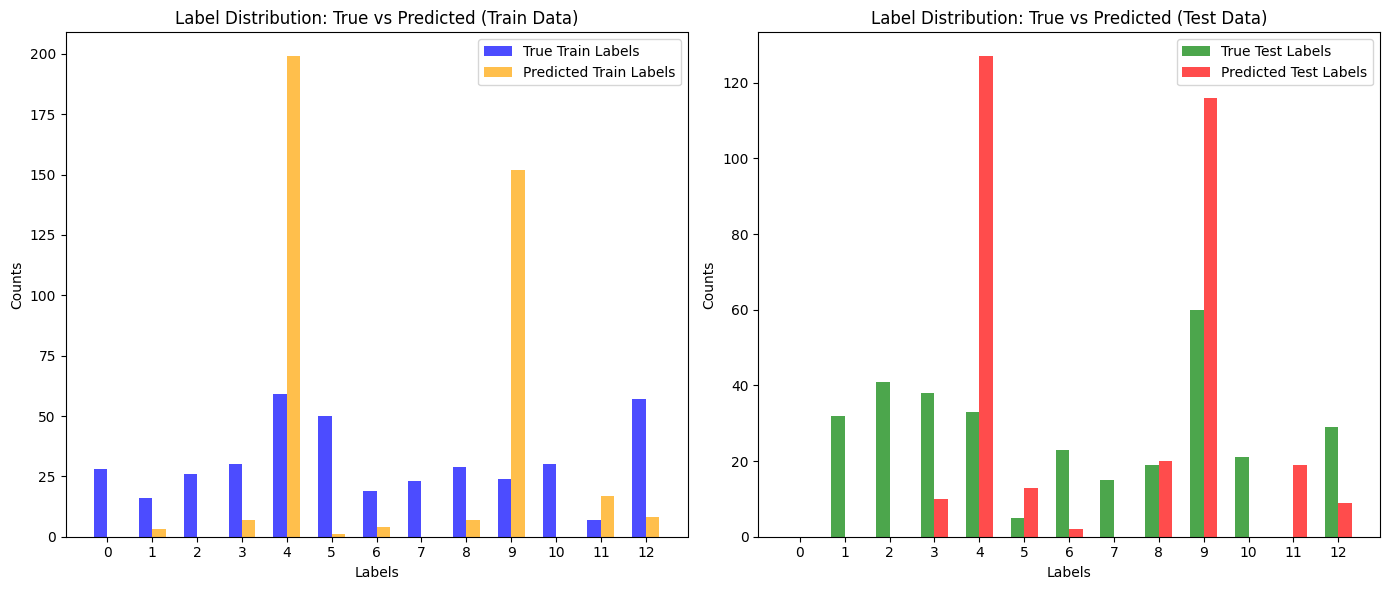

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1331-474/results.json (Modified: 2024-12-07 21:28:40.917196)


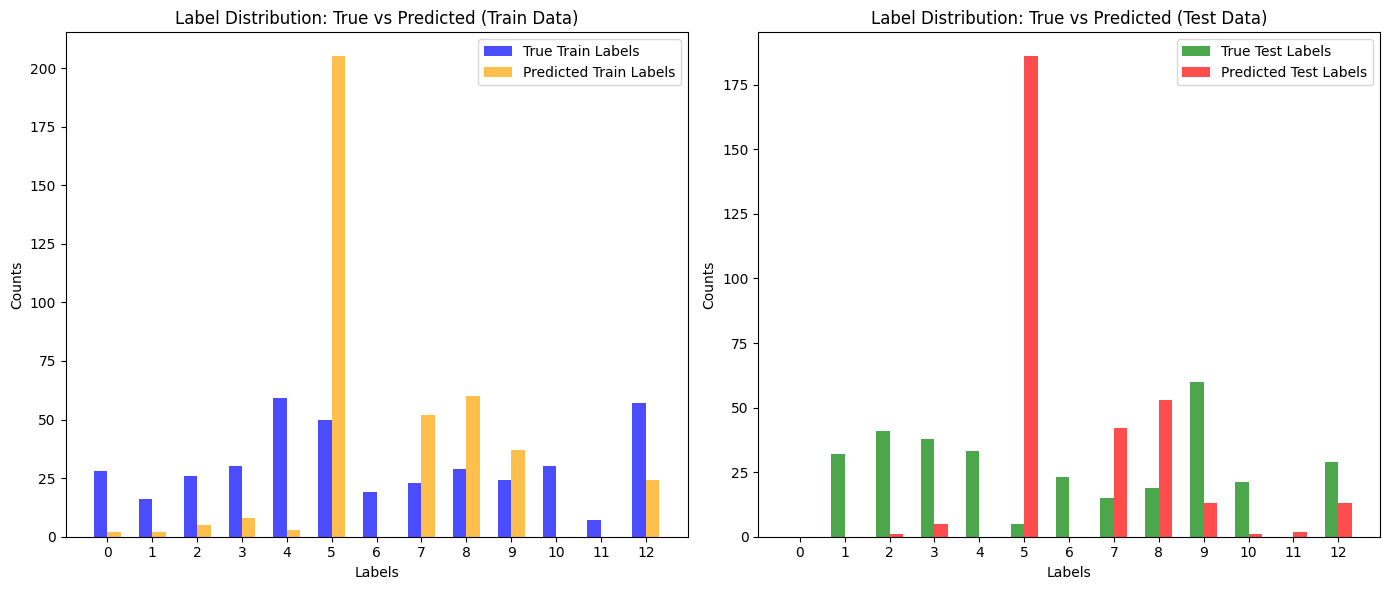

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1281-1107/results.json (Modified: 2024-12-07 20:15:15.592956)


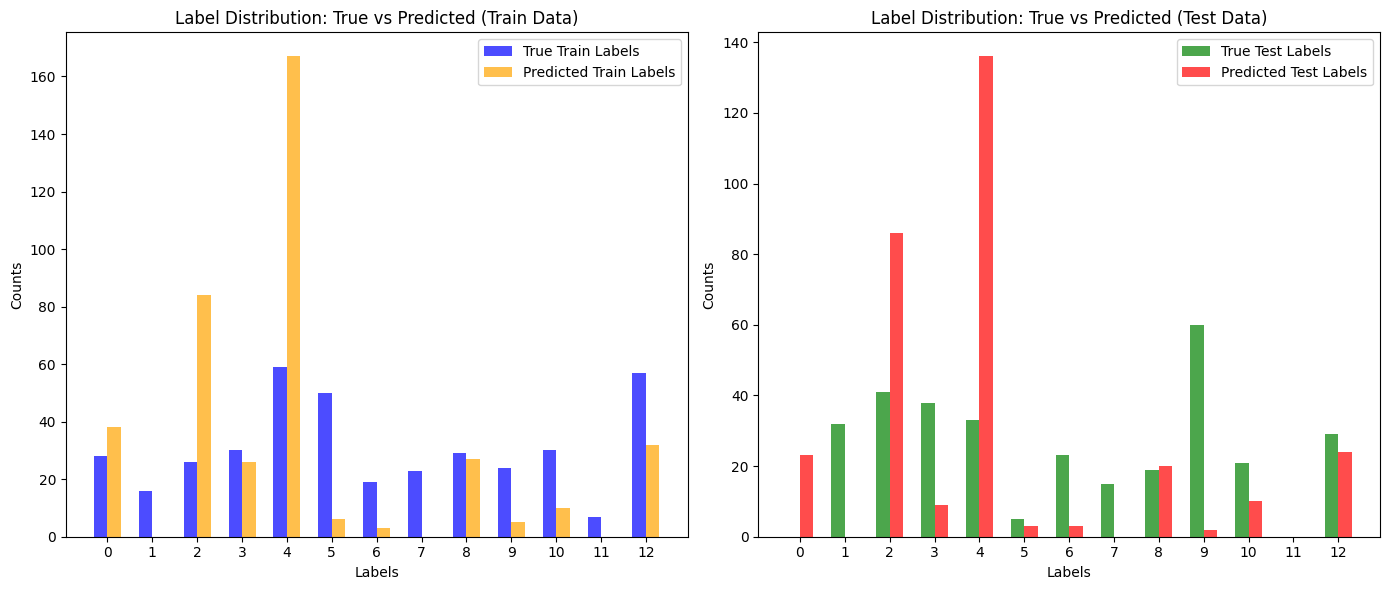

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1281-379/results.json (Modified: 2024-12-07 20:19:22.587296)


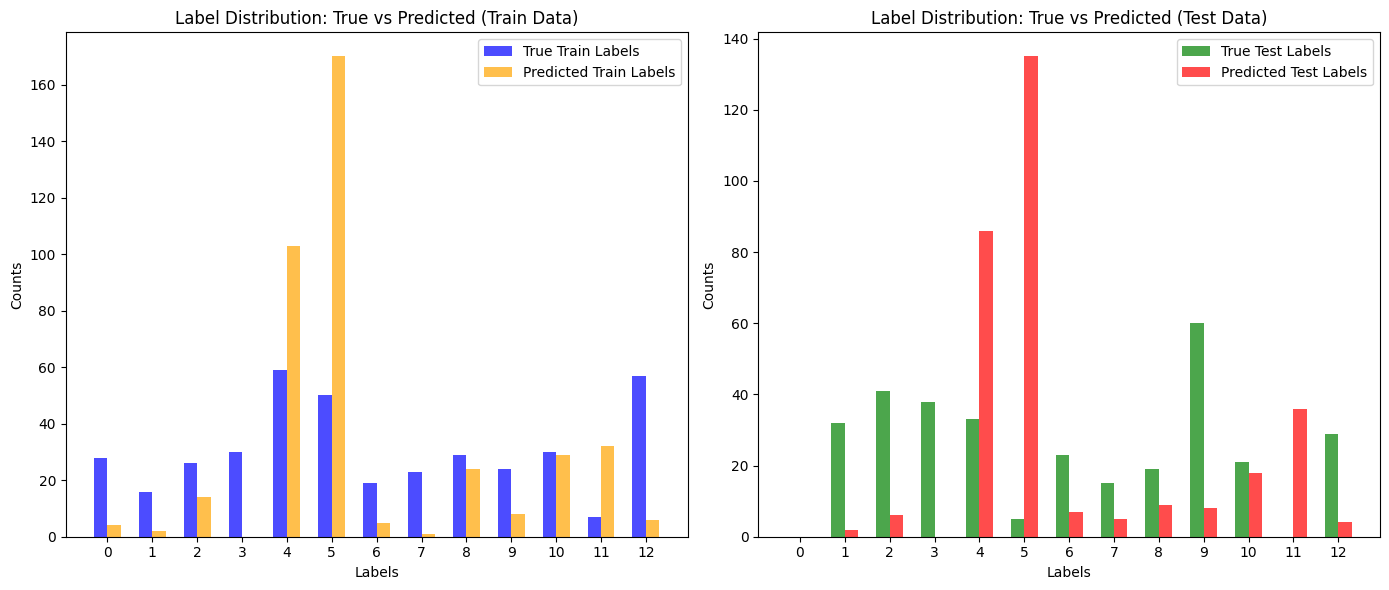

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1256-158/results.json (Modified: 2024-12-07 21:11:47.635597)


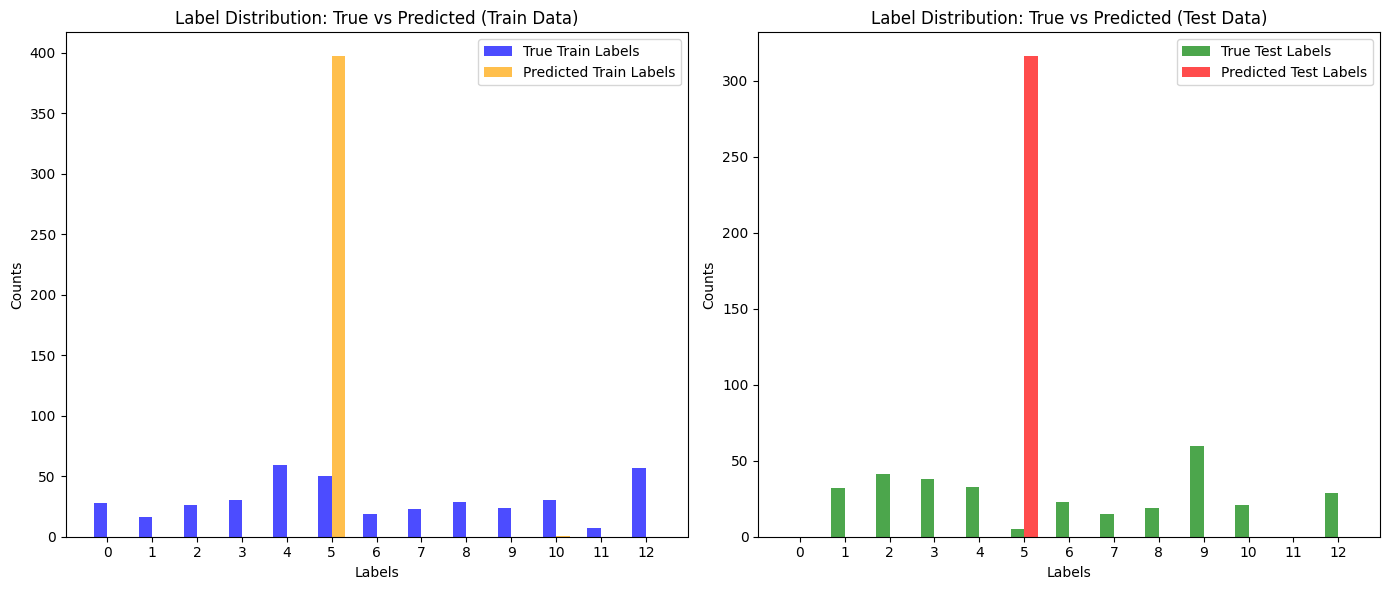

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1231-1550/results.json (Modified: 2024-12-07 20:36:14.491275)


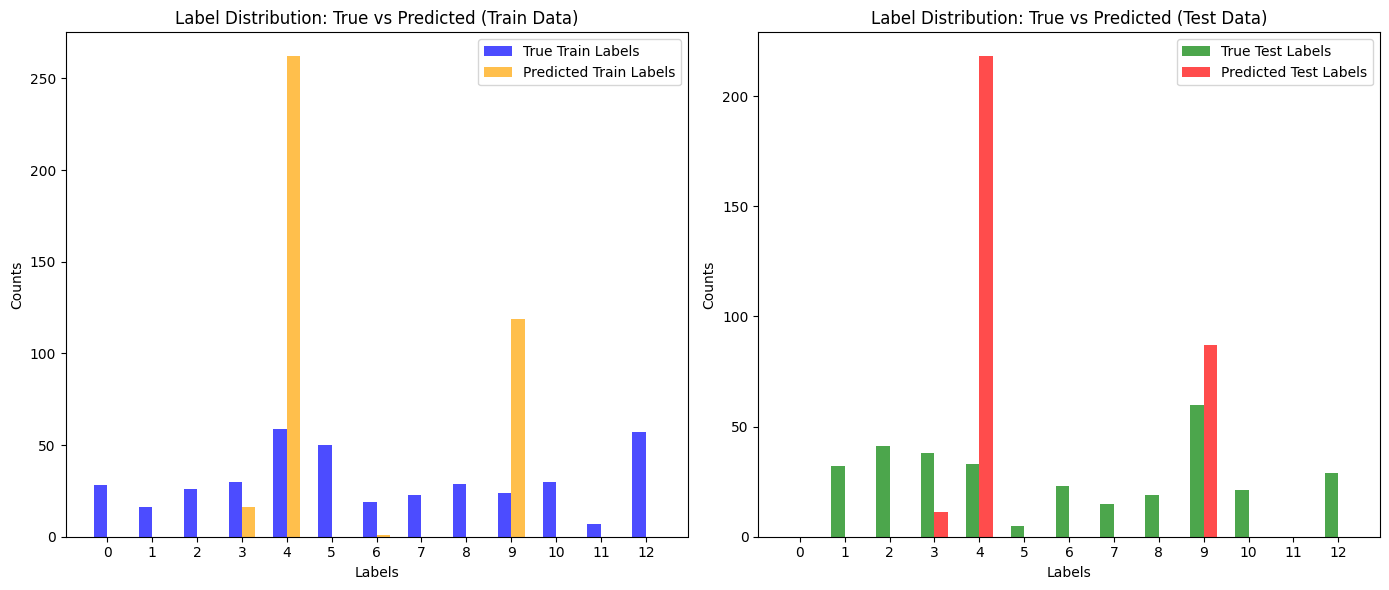

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1231-1487/results.json (Modified: 2024-12-07 20:27:58.603107)


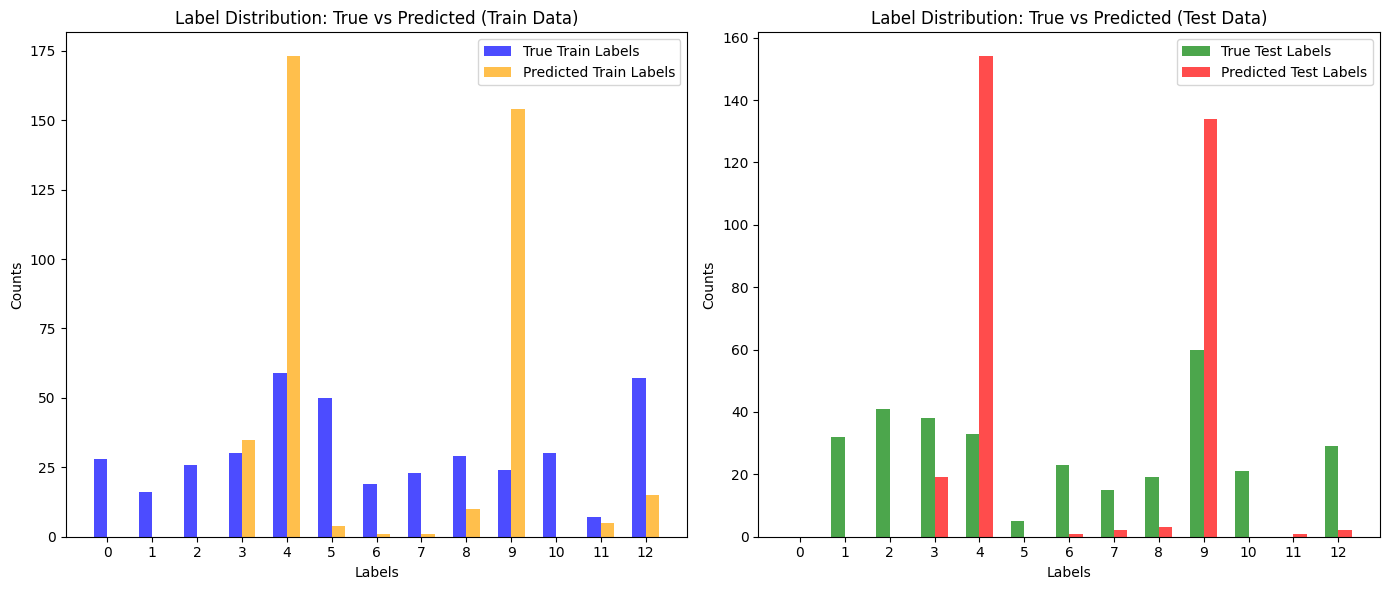

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1231-1392/results.json (Modified: 2024-12-07 21:08:39.229784)


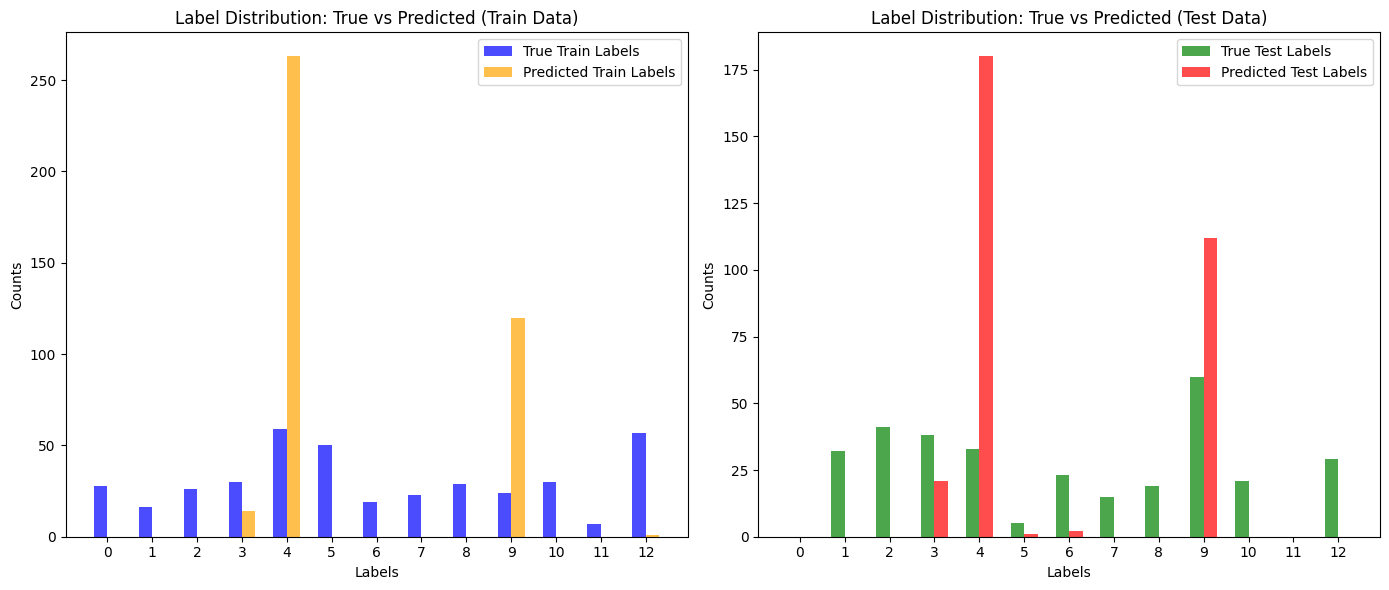

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1231-569/results.json (Modified: 2024-12-07 20:48:14.349679)


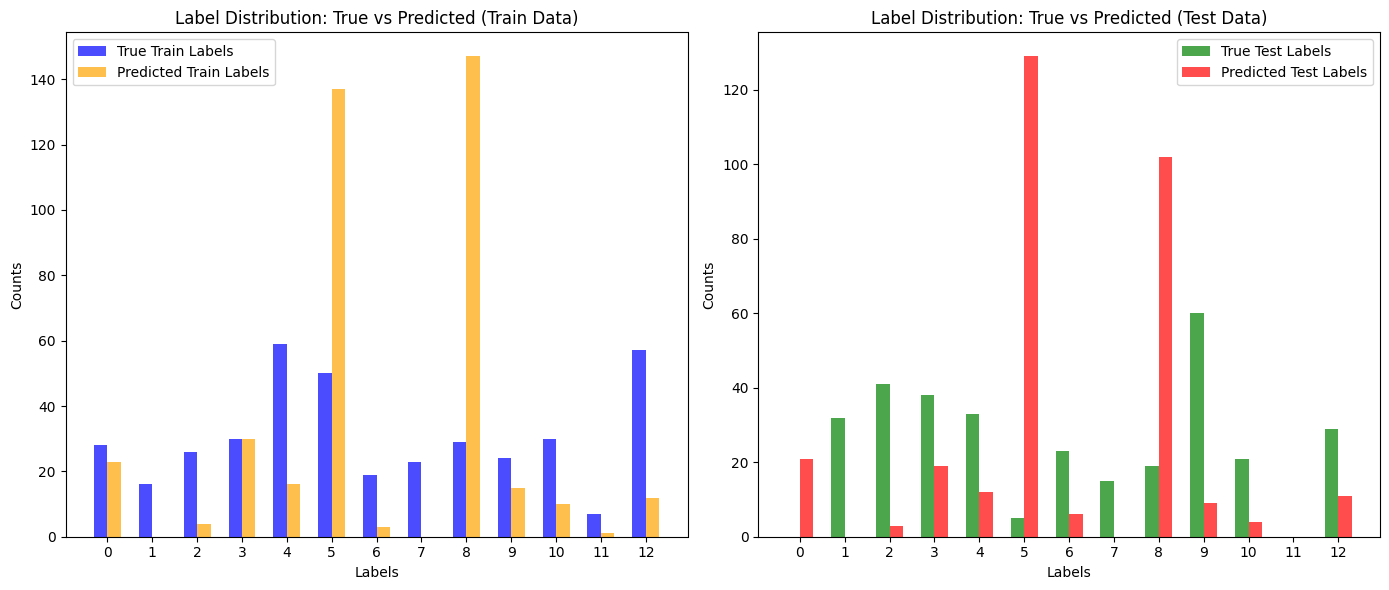

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1155-917/results.json (Modified: 2024-12-07 21:43:39.582014)


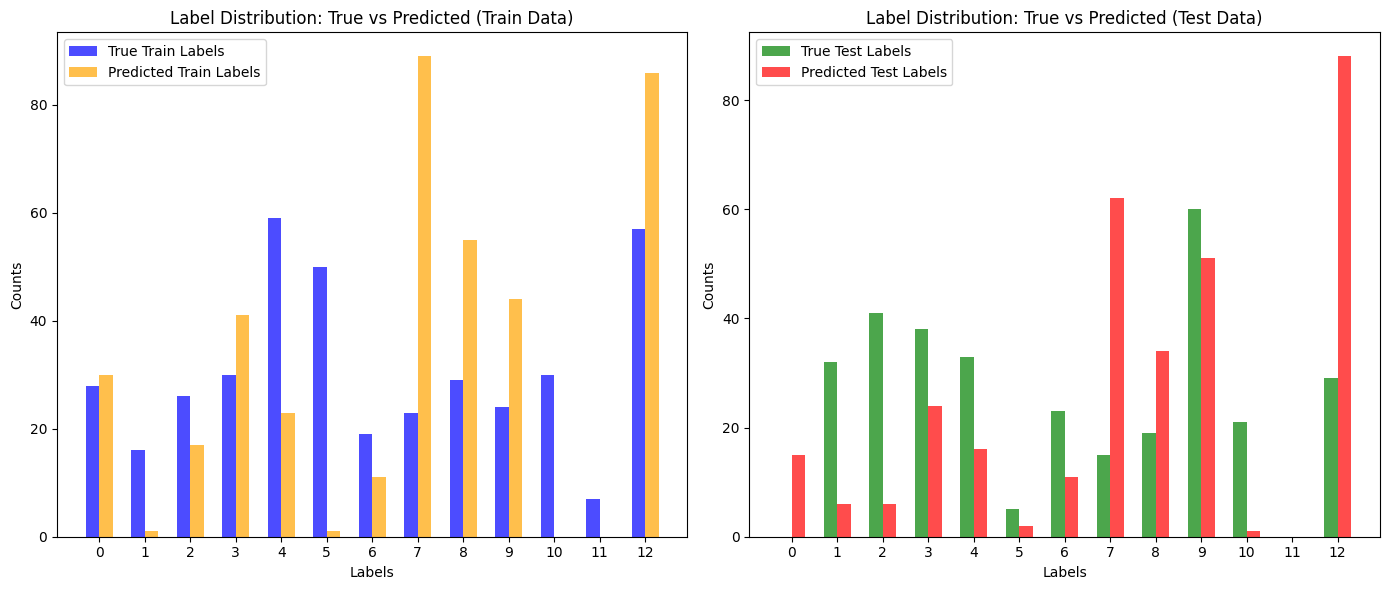

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1155-727/results.json (Modified: 2024-12-07 20:50:26.818876)


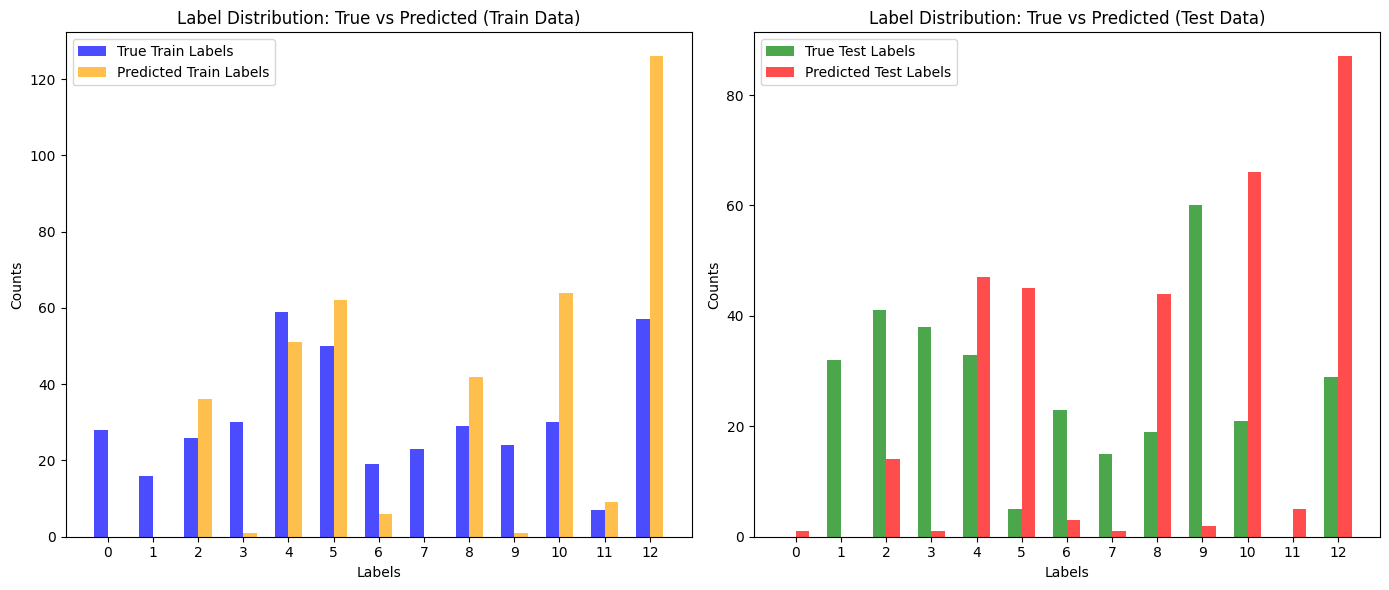

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1155-632/results.json (Modified: 2024-12-07 20:21:24.068176)


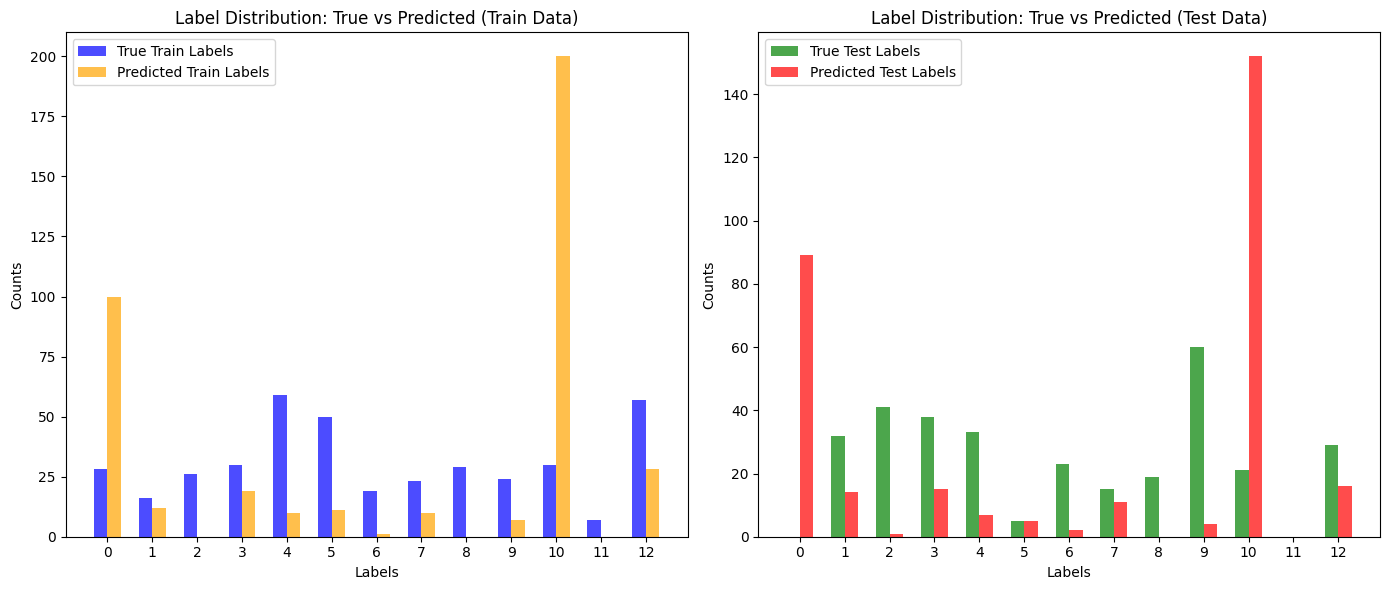

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1130-601/results.json (Modified: 2024-12-07 21:49:40.413469)


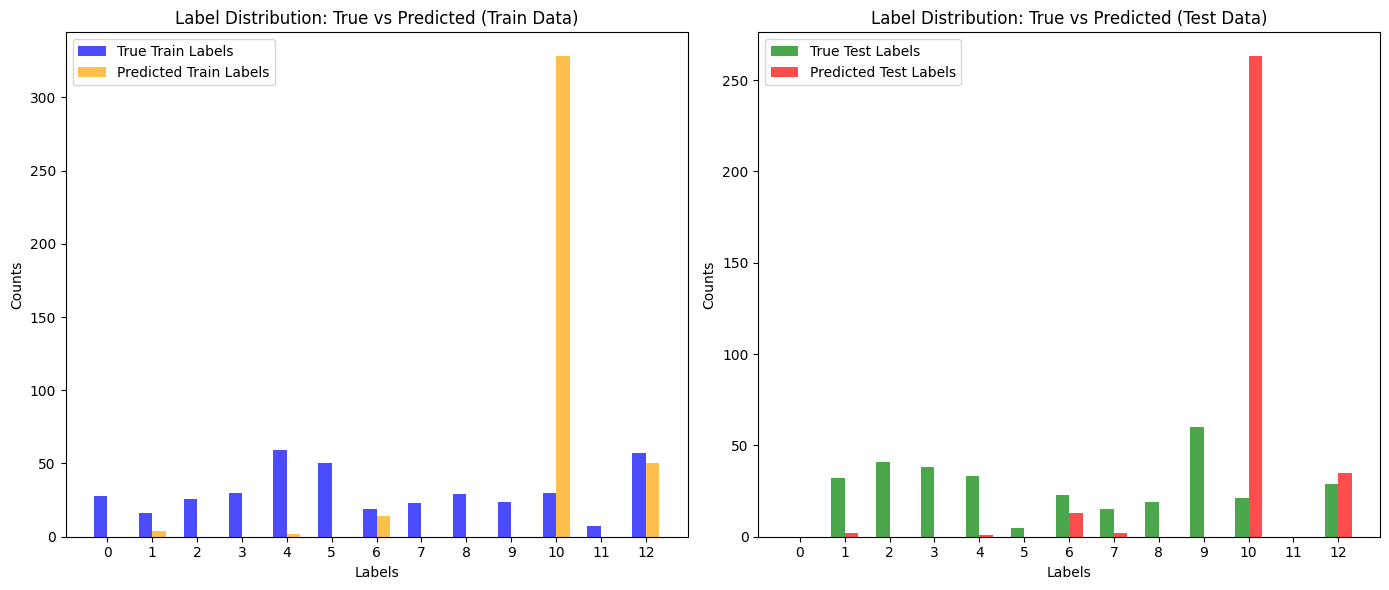

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1130-506/results.json (Modified: 2024-12-07 22:07:17.584700)


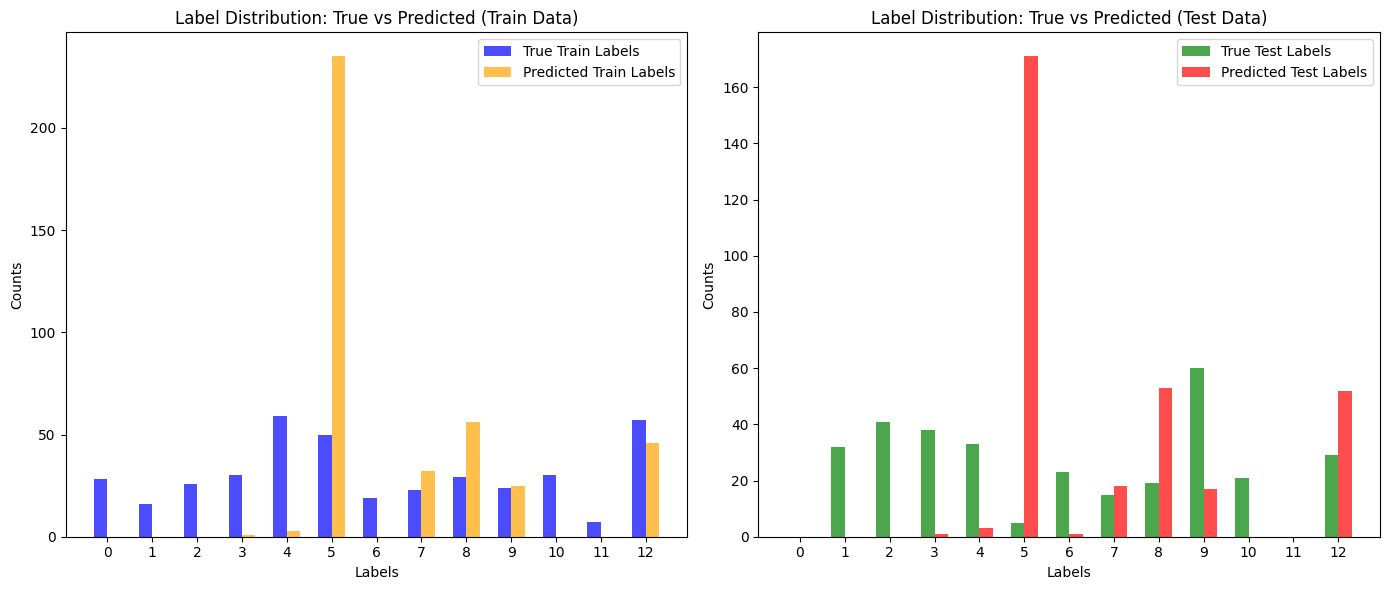

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1055-569/results.json (Modified: 2024-12-07 21:24:22.138741)


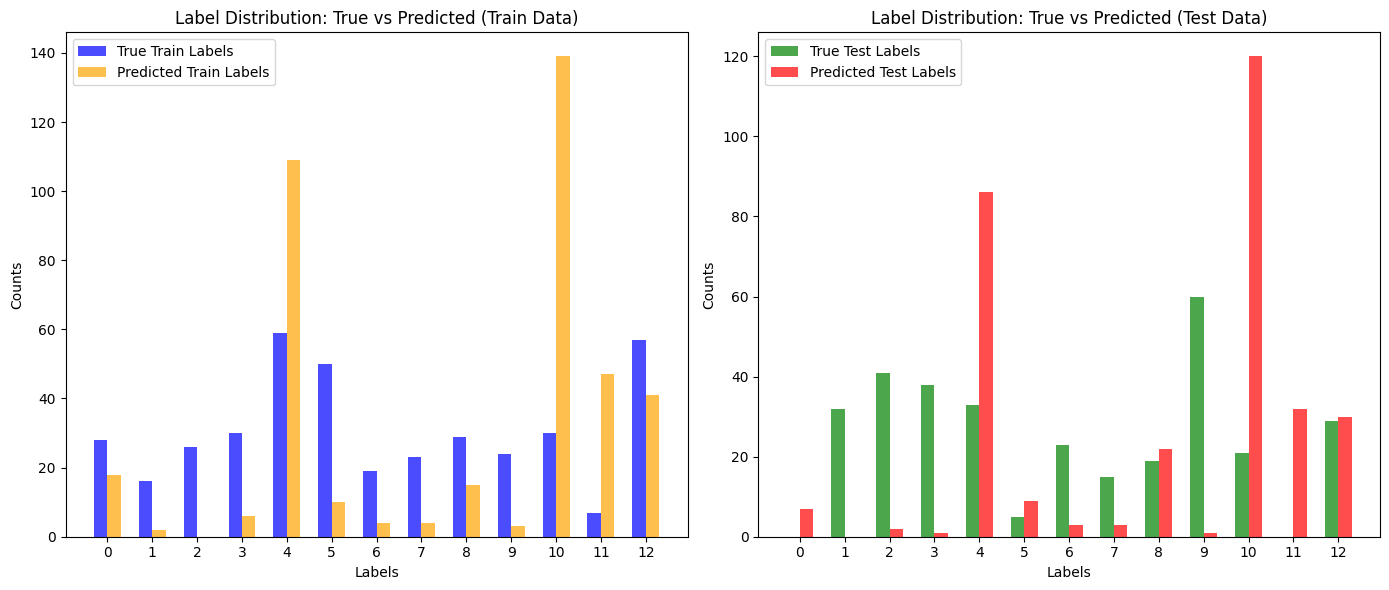

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1055-379/results.json (Modified: 2024-12-07 20:10:53.602476)


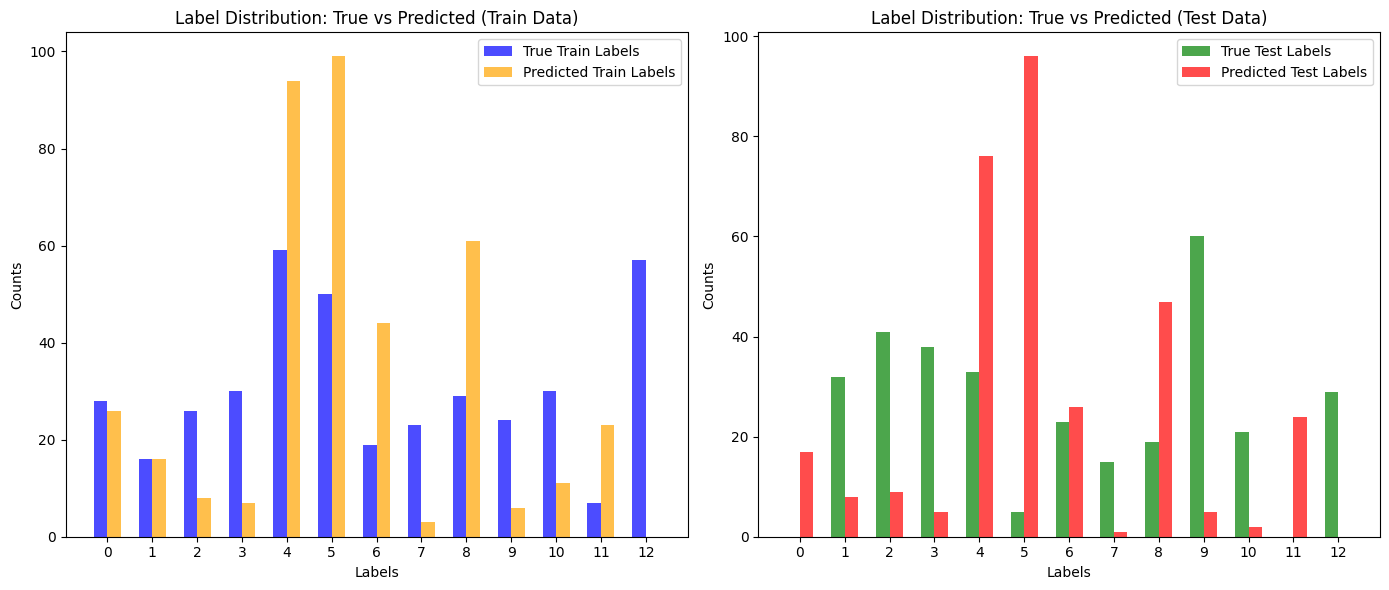

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/1030-601/results.json (Modified: 2024-12-07 20:05:45.595565)


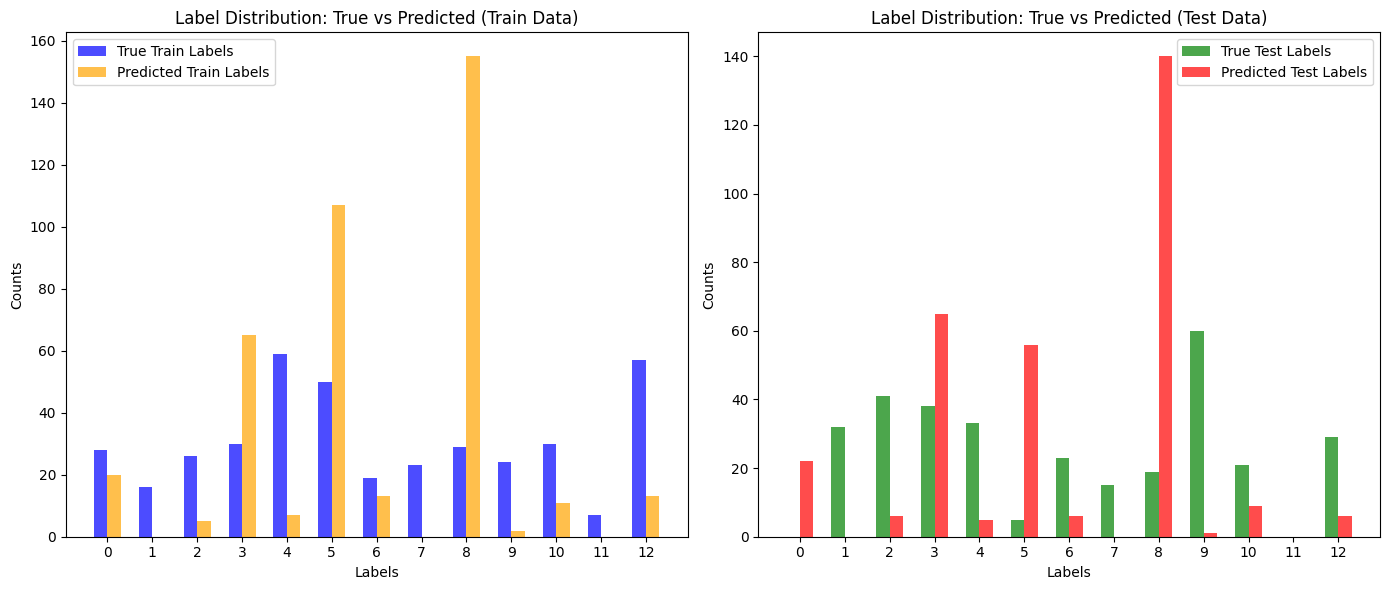

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/979-822/results.json (Modified: 2024-12-07 20:08:36.765182)


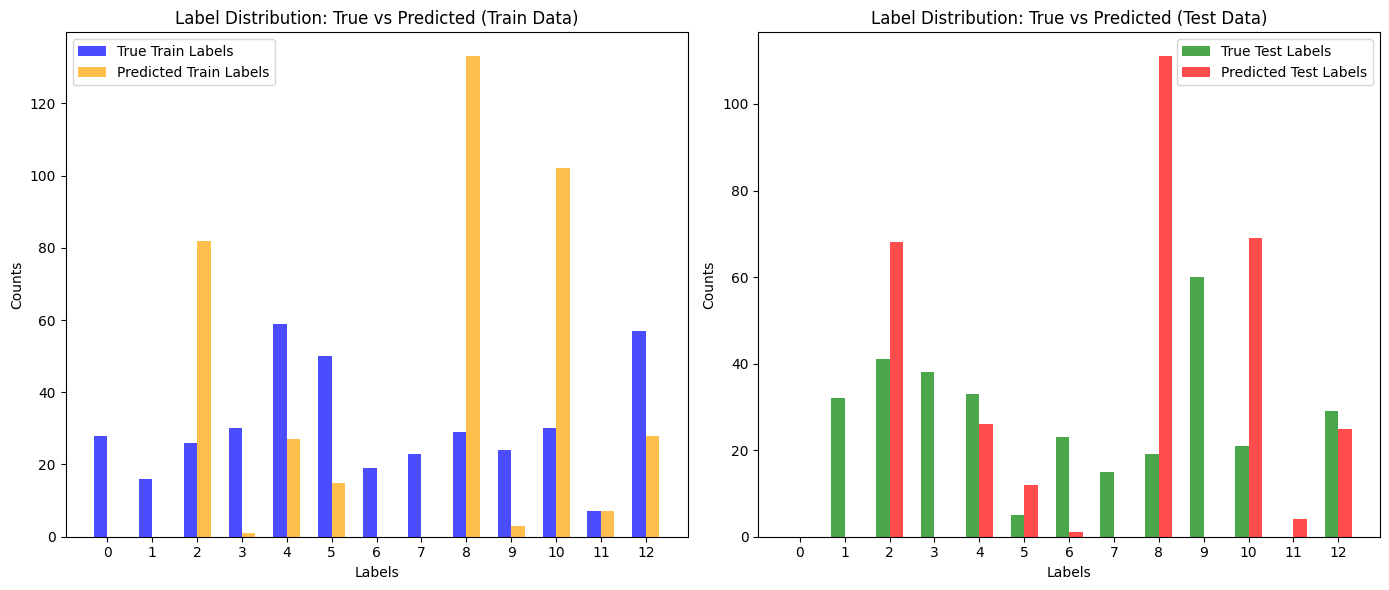

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/979-727/results.json (Modified: 2024-12-07 21:32:45.959655)


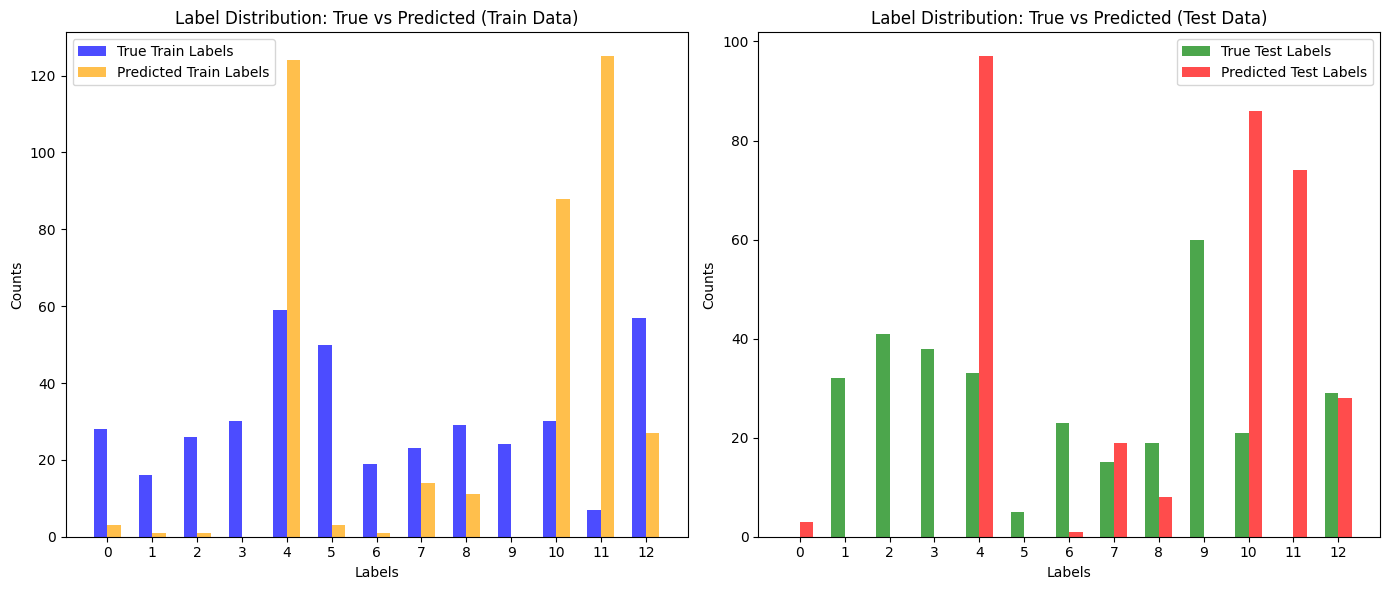

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/954-791/results.json (Modified: 2024-12-07 20:13:11.583782)


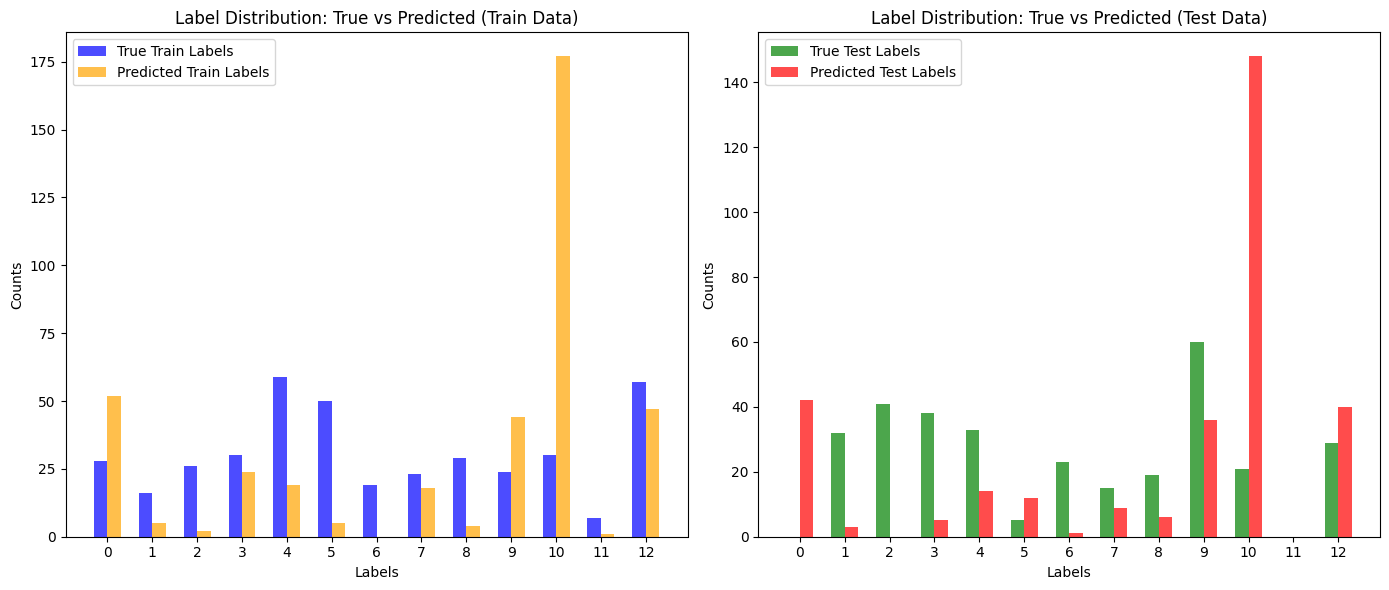

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/954-696/results.json (Modified: 2024-12-07 21:51:42.422633)


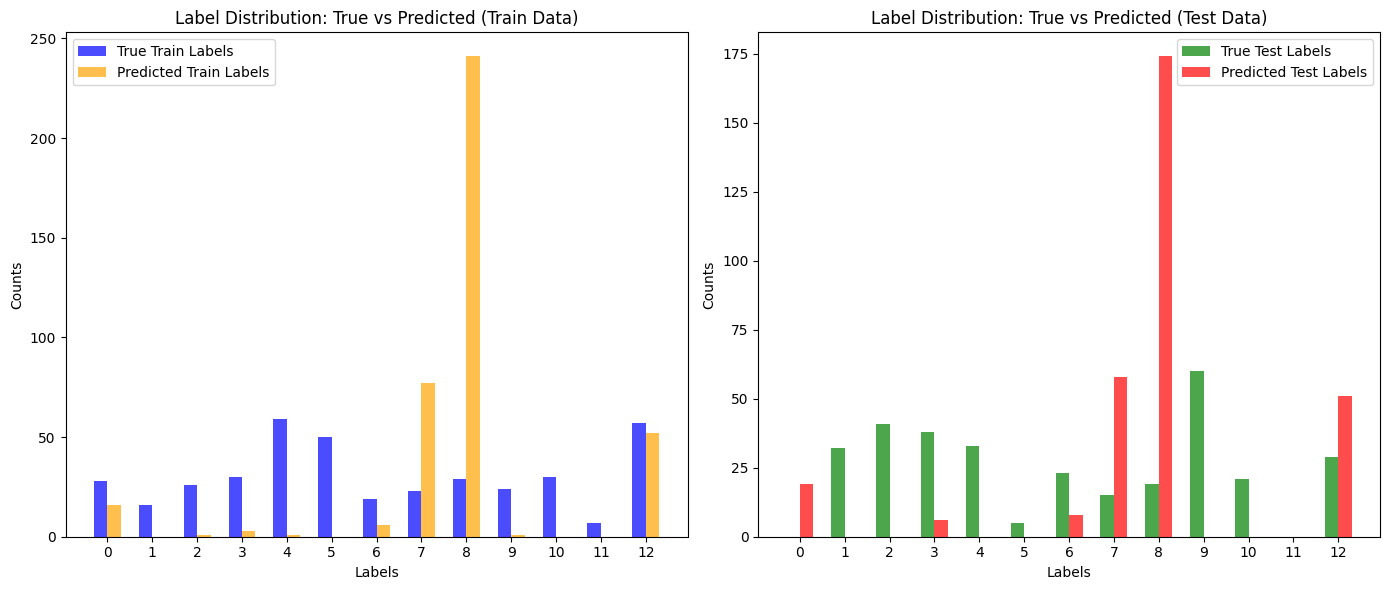

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/904-696/results.json (Modified: 2024-12-07 22:01:57.368484)


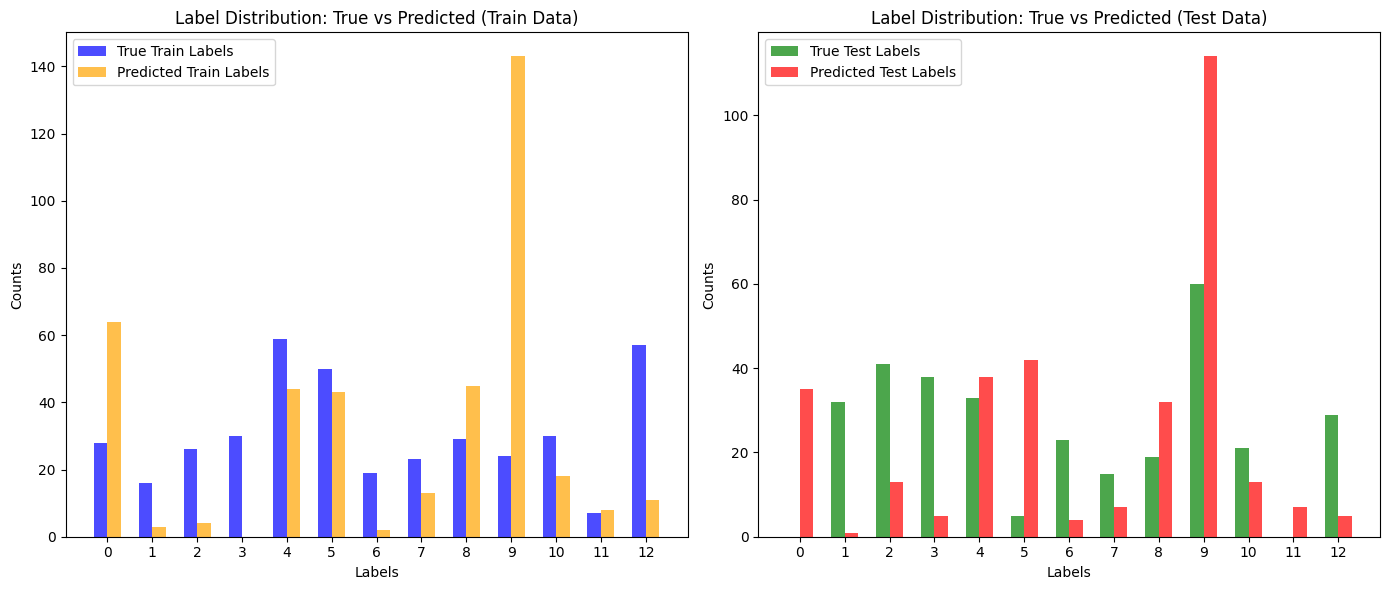

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/904-601/results.json (Modified: 2024-12-07 22:04:01.462134)


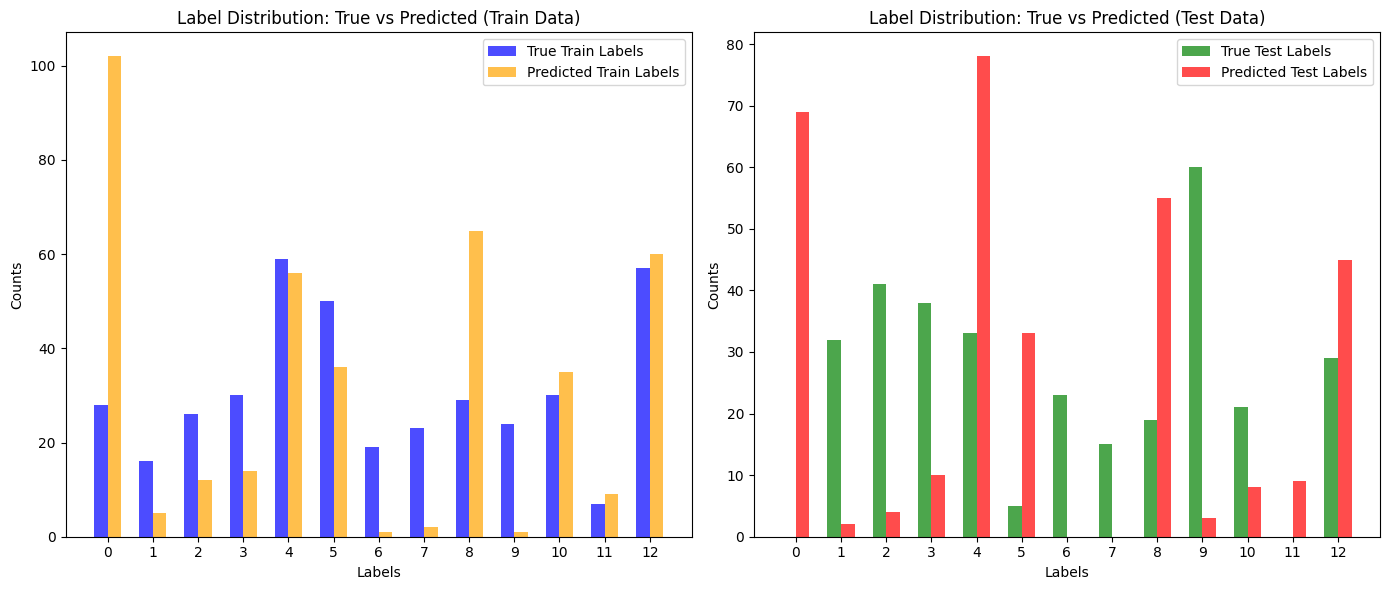

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/879-1012/results.json (Modified: 2024-12-07 21:41:21.428685)


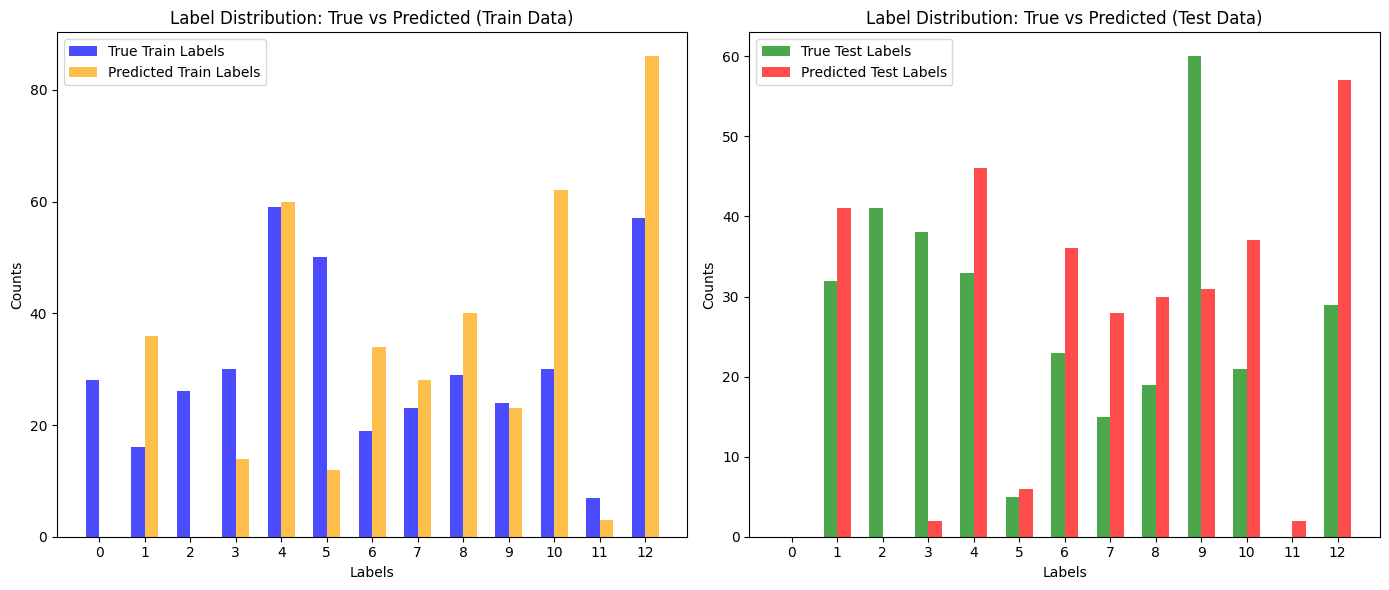

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/829-1044/results.json (Modified: 2024-12-07 21:19:16.763864)


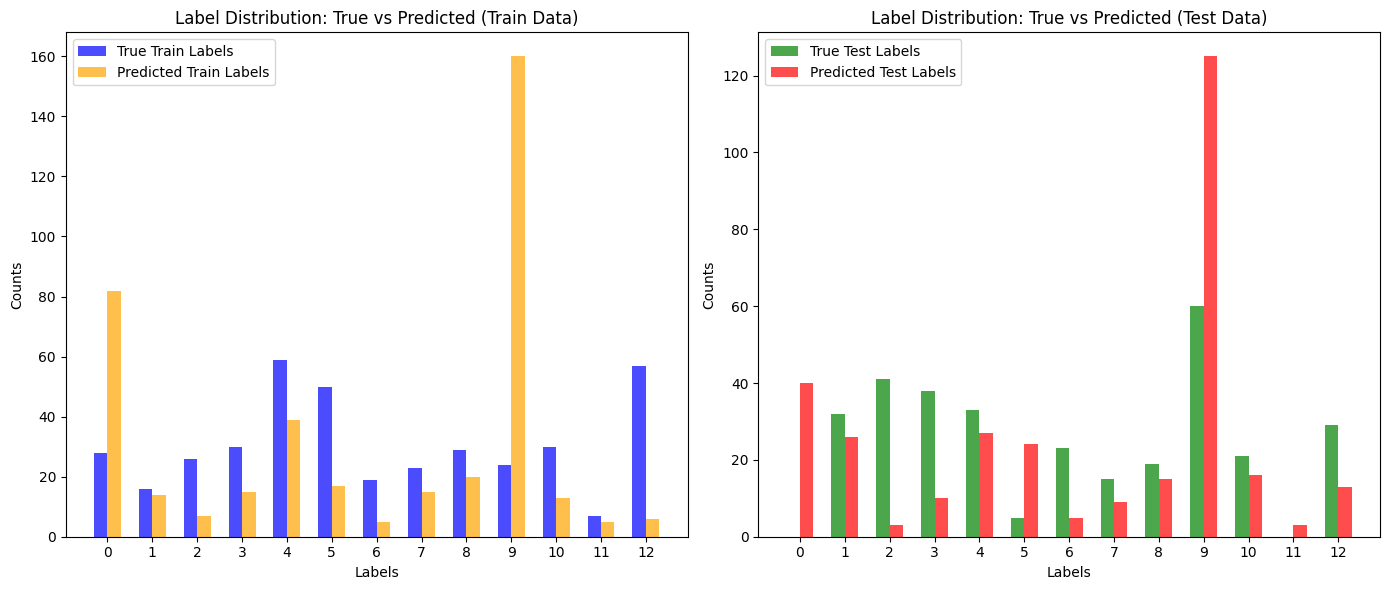

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/753-1012/results.json (Modified: 2024-12-07 21:34:48.384863)


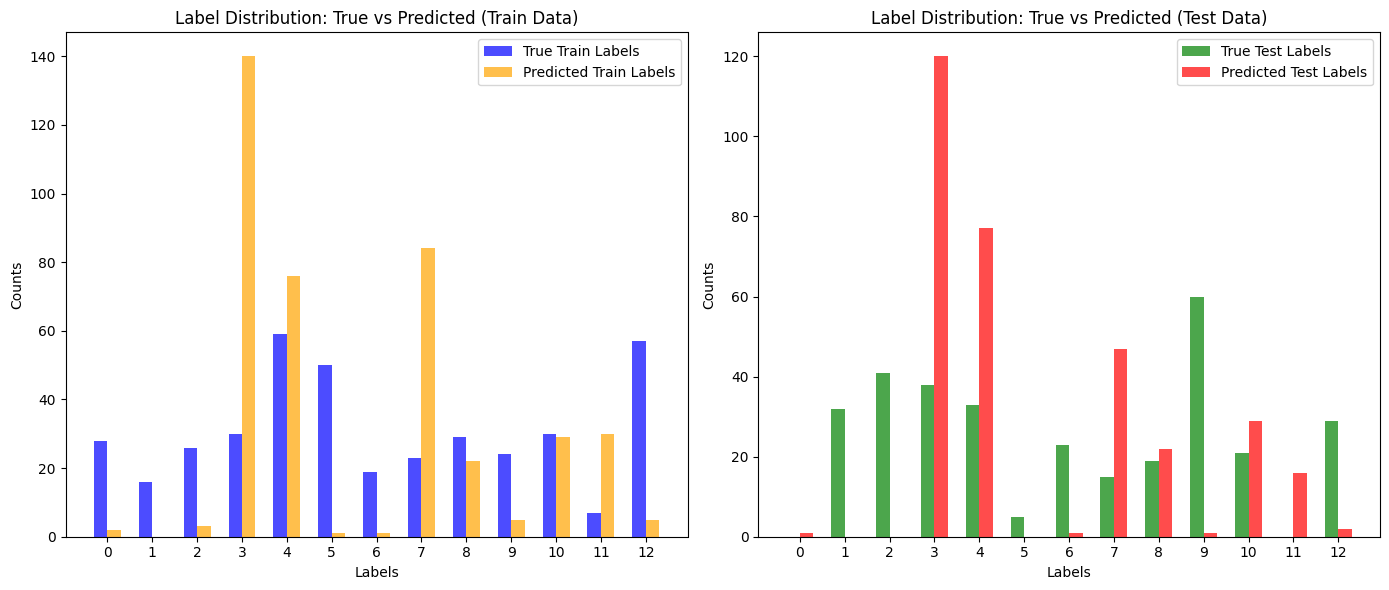

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/678-569/results.json (Modified: 2024-12-07 21:22:06.473464)


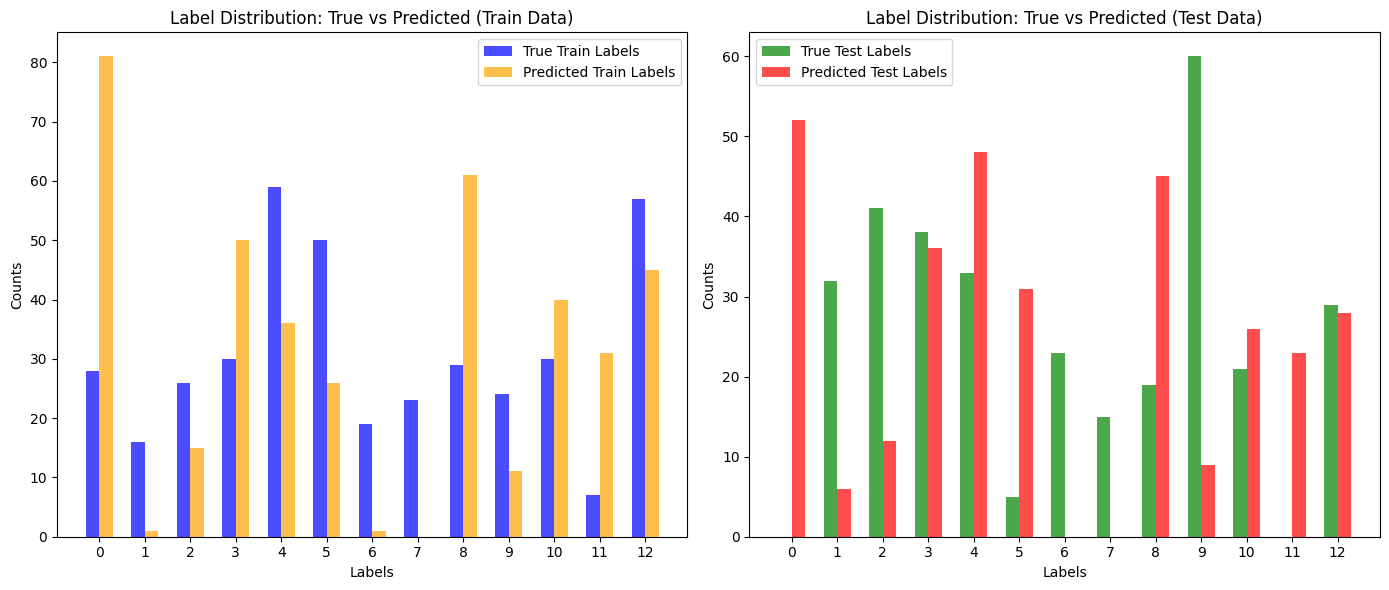

Processing file: /home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo/477-917/results.json (Modified: 2024-12-07 21:26:35.683996)


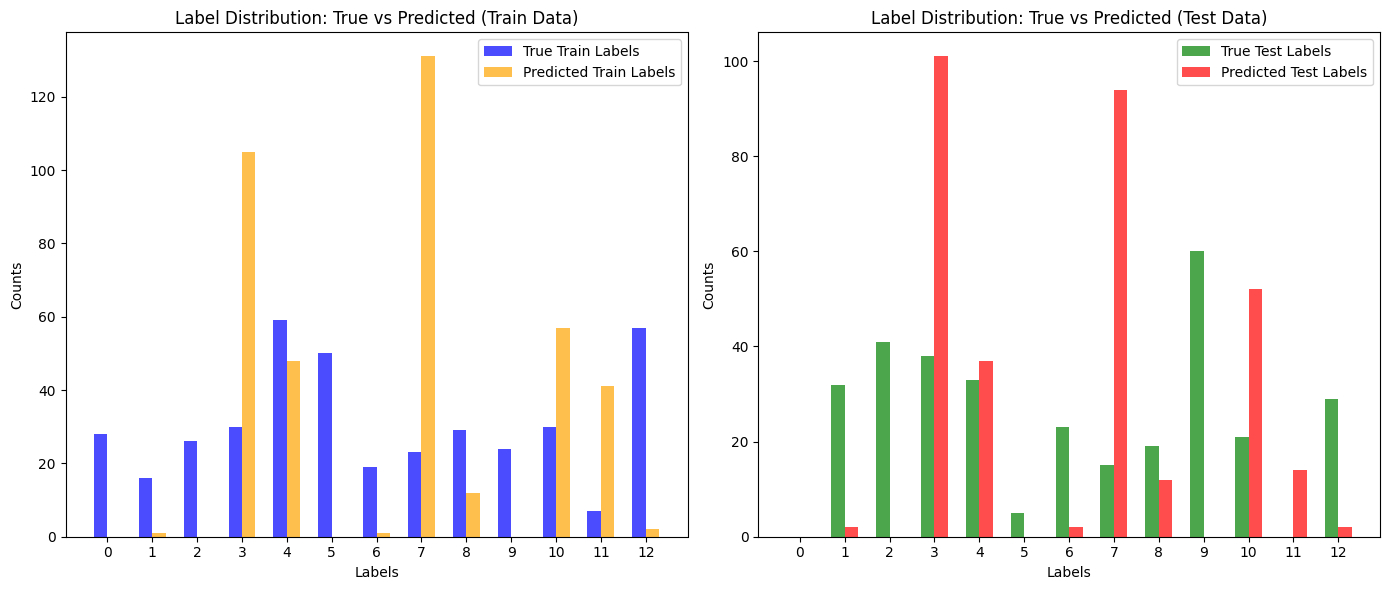

In [8]:
# Folder path and time threshold
base_folder_path = "/home/dalai/GNN_E/data/results/VIB/balanced/1/all_emo"
threshold_time = datetime(2024, 12, 7, 20, 0)

# Collect and sort subdirectory names numerically
subdirectories = [
    os.path.join(base_folder_path, subdir)
    for subdir in os.listdir(base_folder_path)
    if os.path.isdir(os.path.join(base_folder_path, subdir))
]
sorted_subdirectories = sorted(
    subdirectories, key=lambda x: tuple(map(int, x.split('/')[-1].split('-'))), reverse=True
)
# Process each subdirectory in sorted order
for subdir in sorted_subdirectories:
    for file_name in os.listdir(subdir):
        # Process only JSON files
        if file_name.endswith(".json"):
            file_path = os.path.join(subdir, file_name)

            # Get the file's modification time
            mod_time = datetime.fromtimestamp(os.path.getmtime(file_path))

            # Process files created after the threshold time
            if mod_time > threshold_time:
                print(f"Processing file: {file_path} (Modified: {mod_time})")

                # Read the JSON file
                with open(file_path, 'r') as f:
                    results_dict = json.load(f)

                # Extract data
                y_pred_train = results_dict["pred_y_train"]
                y_true_train = results_dict["y_train"]

                y_pred_test = results_dict["pred_y_test"]
                y_true_test = results_dict["y_test"]

                loss_train = results_dict["train_losses"]
                loss_test = results_dict["test_losses"]

                # Apply the functions
                plot_acc(y_pred_train, y_true_train, y_pred_test, y_true_test)
                #plot_confustion_matrix(y_pred_train, y_true_train, y_pred_test, y_true_test)
                #plot_loss(loss_train, loss_test)

# Label evolution

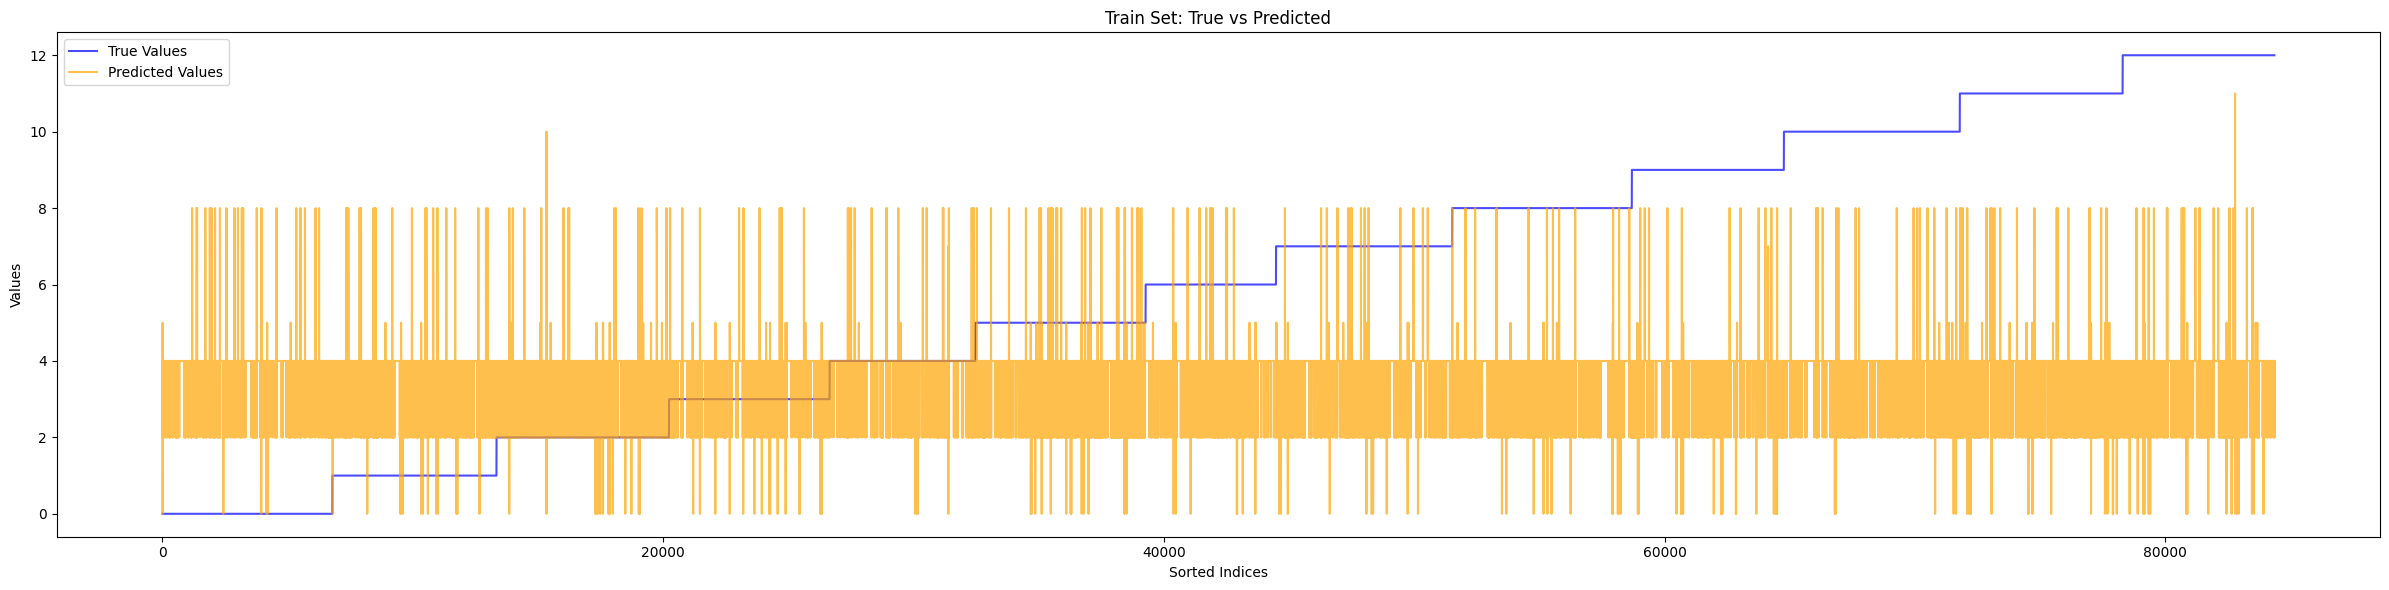

In [6]:
y_pred_train = np.array(results_dict["pred_y_train"])  # Convert to NumPy array if necessary
y_true_train = np.array(results_dict["y_train"])      # Convert to NumPy array if necessary
y_pred_test = np.array(results_dict["pred_y_test"])   # Convert to NumPy array if necessary
y_true_test = np.array(results_dict["y_test"])        # Convert to NumPy array if necessary

# Sort true values and corresponding predictions
sorted_indices_train = np.argsort(y_true_train)
y_true_train_sorted = y_true_train[sorted_indices_train]
y_pred_train_sorted = y_pred_train[sorted_indices_train]

sorted_indices_test = np.argsort(y_true_test)
y_true_test_sorted = y_true_test[sorted_indices_test]
y_pred_test_sorted = y_pred_test[sorted_indices_test]

# Create a figure with two subplots (2 rows, 2 columns)
fig, axes = plt.subplots( figsize=(24, 6))

# Plot for training set
axes.plot(range(len(y_true_train_sorted)), y_true_train_sorted, label="True Values", color='blue', alpha=0.7)
axes.plot(range(len(y_pred_train_sorted)), y_pred_train_sorted, label="Predicted Values", color='orange', alpha=0.7)
axes.set_title("Train Set: True vs Predicted")
axes.set_xlabel("Sorted Indices")
axes.set_ylabel("Values")
axes.legend()

# # Plot for test set
# axes[1].plot(range(len(y_true_test_sorted)), y_true_test_sorted, label="True Values", color='blue', alpha=0.7)
# axes[1].plot(range(len(y_pred_test_sorted)), y_pred_test_sorted, label="Predicted Values", color='orange', alpha=0.7)
# axes[1].set_title("Test Set: True vs Predicted")
# axes[1].set_xlabel("Sorted Indices")
# axes[1].set_ylabel("Values")
# axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Graph Learnt

In [8]:
# Load the .npz file
data_from_npz = np.load("data/results/VIB/283/adj_test.npz")

# Check the available keys
print(data_from_npz.files)

# Access the matrices grouped by label
label = '5'  # Example label (you can loop through all or access specific labels)
adj_list = data_from_npz[label]  # List of adjacency matrices for label '5'
print(adj_list.shape)

# Access the labels stored separately
labels = data_from_npz['labels']
print(labels.shape)  # Shape of the labels

# Print the shapes of the loaded data
print(adj_list[0].shape)  # Shape of the first adjacency matrix for this label

FileNotFoundError: [Errno 2] No such file or directory: 'data/results/VIB/283/adj_test.npz'

(4566, 414, 414)
(414, 414)


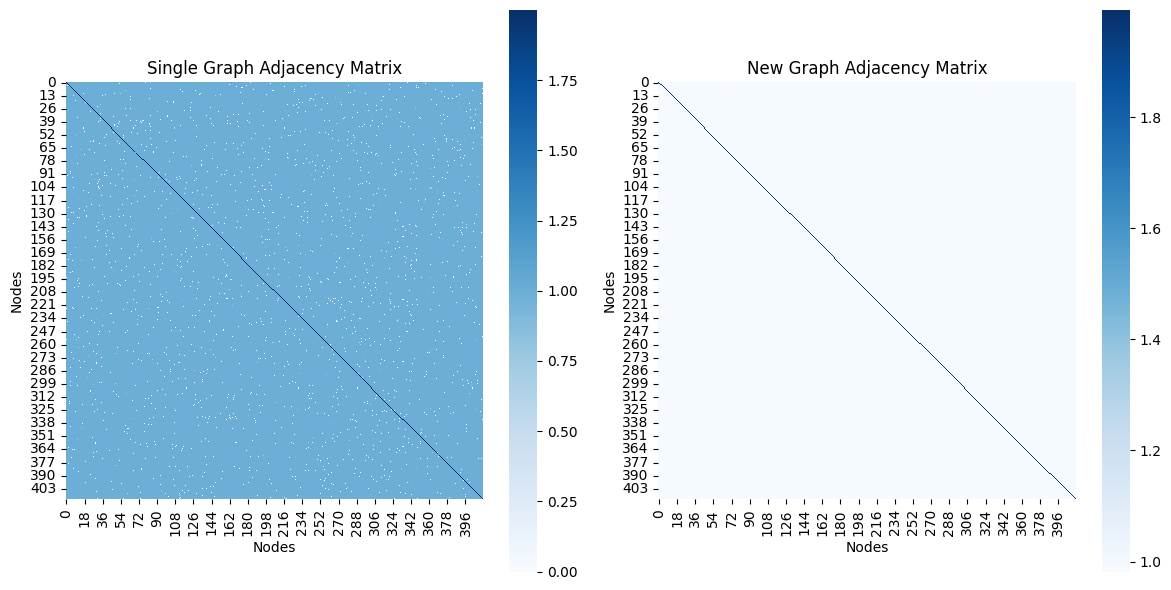

In [ ]:
# Select a specific emo
label = '5'  # Example label (you can loop through all or access specific labels)
adj_list_single_emo = data_from_npz[label]  # List of adjacency matrices for label '5'
print(adj_list_single_emo.shape)

mean_adj_list_single_emo = np.mean(adj_list_single_emo, axis=0)
print(mean_adj_list_single_emo.shape)


# Set up the matplotlib figure
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # Create 2 subplots side by side

# Plot the initial graph adjacency matrix
sns.heatmap(adj_list_single_emo[0], cmap='Blues', ax=ax[0], square=True, cbar=True)
ax[0].set_title('Single Graph Adjacency Matrix')
ax[0].set_xlabel('Nodes')
ax[0].set_ylabel('Nodes')

# Plot the new graph adjacency matrix/home/dalai/GNN_E/data/results/GAT/balanced/1/all_emo/607/results.json
sns.heatmap(mean_adj_list_single_emo, cmap='Blues', ax=ax[1], square=True, cbar=True)
ax[1].set_title('New Graph Adjacency Matrix')
ax[1].set_xlabel('Nodes')
ax[1].set_ylabel('Nodes')

# Adjust layout
plt.tight_layout()
plt.show()